## Identifying/combining risk factors for brain atrophy from different cohorts
#### Presenter: Yi-Han Hu, Postdoc fellow, Laboratory of Epidemiology & Population Science, NIA 

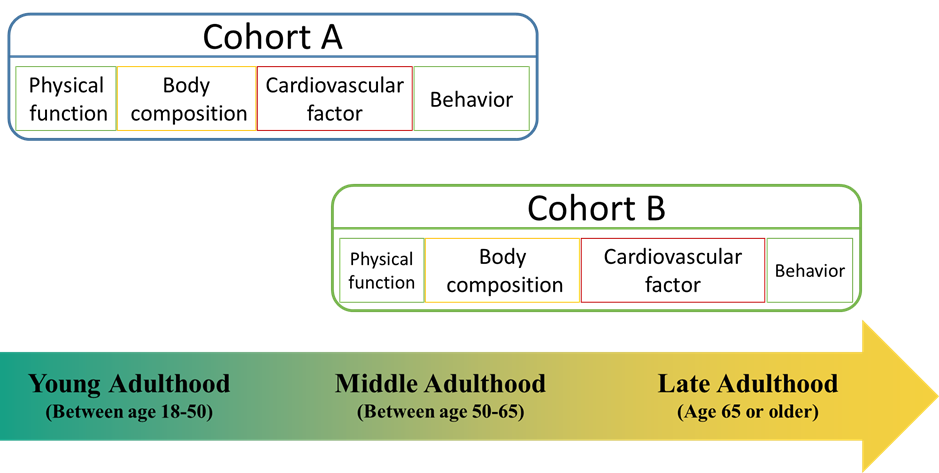

### Objectives:
- Identify the top influential features/risk factors in terms of brain volumn (Main focus for today's talk)
- Combine the rsik factors from different cohorts

### Methods:
- Data: Age, Gene/Environment Susceptibility - Reykjavik Study (AGES-RS)
    - 5445 subjects with more than 800 features
- Approach:
    - **Run model(s) directly**:
    Preprocess data and throw all the features in the model(s), and see which features were select from the model
    - **PCA --> model**:
    Run PCA using all the features in the data set and throw those PCs into model(s)
    - **Cluster --> PCA --> model**:
    Clustering all the features to identify similar variables and run PCA for each cluster and then modeling.  

## Data retrieval and preprocessing for ML

In [62]:
#Import library
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 900)
pd.set_option('display.width', 1000)
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

In [63]:
# Retrieve pre-processed SAS data containing derived variables and MRI data
AGES_data = pd.read_sas('G:/Hank/Google Drive/projects/ML_AGES/Dataset/ages_derived2019_mridata.sas7bdat')

In [64]:
AGES_data['COGSTATUS'].unique()

array([b'nor', b'dem', nan, b'mci'], dtype=object)

In [65]:
# Remove demented cases
AGES_data = AGES_data[AGES_data['COGSTATUS']!=b'dem']

### Preprocess data
- Recode string type variables and create dummy variables
    - Remove date or string variables
- Imputation
    - Logical imputation (some types of item nonresponse. ex., smoking quantity for non-smokers)
    - Mean imputation by group (age bin and sex)
- Create dummy variables for categorical variables with >= 3 categories
- Normalization for all continuous/ordinal variables

#### Recode character type variables and create dummy variables

In [66]:
# Recode character type variables and create dummy variables
AGES_data = pd.get_dummies(AGES_data, columns=['DSMMPF', 'DSMMPF1', 'MINIPF', 'nmedcategory'], prefix=['DSMMPF', 'DSMMPF1', 'MINIPF', 'nmedcategory'], drop_first=True)

In [67]:
# Remove strings and date type columns
AGES_data = AGES_data.select_dtypes(exclude=['object', 'datetime64'])
AGES_data.shape

(5445, 826)

#### Recode varaibles

Define function for recoding variables

In [68]:
# define a function to recode value >=7 to missing
def rec1(series):
    if series >= 7:
        return None
    else:
        return series
def rec2(series):
    if 5 >= series >= 0:
        return series
    else:
        return None
def rec_age(age):
    if 70 >= age > 65:
        return 1
    elif 75 >= age > 70:
        return 2
    elif 80 >= age > 75:
        return 3
    elif 85 >= age > 80:
        return 4
    elif age >= 85:
        return 5
    else:
        return None

Logical imputation & Recode unknown to missing

In [69]:
# Logical imputation
AGES_data.fillna({'HEALHTN1':0, 'HEALHTN2':0, 'HEALHTN3':0, 'HEALHTN4':0, 'HEALH401':0, 'HEALH402':0, 'HEALH403':0, 'HEALH404':0}, inplace=True)
AGES_data.loc[(AGES_data['BIG_MICROBLD'].isnull()) & (AGES_data['MRI_STATUS']==1), 'BIG_MICROBLD']=0
AGES_data.loc[(AGES_data['MBLPLC_1'].isnull()) & (AGES_data['MRI_STATUS']==1), 'MBLPLC_1']=0
AGES_data.loc[(AGES_data['MBLPLC_2'].isnull()) & (AGES_data['MRI_STATUS']==1), 'MBLPLC_2']=0
AGES_data.loc[(AGES_data['MBLPLC_3'].isnull()) & (AGES_data['MRI_STATUS']==1), 'MBLPLC_3']=0
AGES_data.loc[(AGES_data['MBLPLC_4'].isnull()) & (AGES_data['MRI_STATUS']==1), 'MBLPLC_4']=0
AGES_data.loc[(AGES_data['MBLPLC_5'].isnull()) & (AGES_data['MRI_STATUS']==1), 'MBLPLC_5']=0
AGES_data.loc[(AGES_data['MBLPLC_6'].isnull()) & (AGES_data['MRI_STATUS']==1), 'MBLPLC_6']=0
AGES_data.loc[(AGES_data['diabetesMedcount'].isnull()) & (AGES_data['diabetesMed']==0), 'diabetesMedcount']=0
AGES_data.loc[(AGES_data['dmmedinsulincount'].isnull()) & (AGES_data['dmmedinsulin']==0), 'dmmedinsulincount']=0
AGES_data.loc[(AGES_data['dmmedoralcount'].isnull()) & (AGES_data['dmmedoral']==0), 'dmmedoralcount']=0
AGES_data.loc[(AGES_data['cholmedcount'].isnull()) & (AGES_data['cholmed']==0), 'cholmedcount']=0
AGES_data.loc[(AGES_data['bblockercount'].isnull()) & (AGES_data['bblocker']==0), 'bblockercount']=0
AGES_data.loc[(AGES_data['statinscount'].isnull()) & (AGES_data['statins']==0), 'statinscount']=0
AGES_data.loc[(AGES_data['PACKAYEAR'].isnull()) & (AGES_data['SMOKERCR']==0), 'PACKAYEAR']=0
AGES_data.loc[(AGES_data['PACK_YEARS'].isnull()) & (AGES_data['SMOKERCR']==0), 'PACK_YEARS']=0
AGES_data.loc[(AGES_data['C_YEAR'].isnull()) & (AGES_data['SMOKERCR']==0), 'C_YEAR']=0
AGES_data.loc[(AGES_data['CIGARAYEAR'].isnull()) & (AGES_data['SMOKERPI']==0), 'CIGARAYEAR']=0
AGES_data.loc[(AGES_data['CIGAR_YEARS'].isnull()) & (AGES_data['SMOKERPI']==0), 'CIGAR_YEARS']=0
AGES_data.loc[(AGES_data['p_YEAR'].isnull()) & (AGES_data['SMOKERPI']==0), 'p_YEAR']=0
AGES_data.loc[(AGES_data['CHEWAYEAR'].isnull()) & ((AGES_data['SMOKERSN']==0) | (AGES_data['SMOKERSN']==1)), 'CHEWAYEAR']=0
AGES_data.loc[(AGES_data['CHEW_YEARS'].isnull()) & ((AGES_data['SMOKERSN']==0) | (AGES_data['SMOKERSN']==1)), 'CHEW_YEARS']=0
AGES_data.loc[(AGES_data['CH_YEAR'].isnull()) & (AGES_data['SMOKERSN']==0) | (AGES_data['SMOKERSN']==1), 'CH_YEAR']=0
AGES_data.loc[(AGES_data['QUE2ALHO'].isnull()) & (AGES_data['QUE2ALCN']==0), 'QUE2ALHO']=0
AGES_data.loc[(AGES_data['QUE2ALHM'].isnull()) & (AGES_data['QUE2ALCN']==0), 'QUE2ALHM']=0
AGES_data.loc[(AGES_data['QUE2AMAO'].isnull()) & (AGES_data['QUE2ALMA']==0), 'QUE2AMAO']=0
AGES_data.loc[(AGES_data['QUE2AMAQ'].isnull()) & (AGES_data['QUE2ALMA']==0), 'QUE2AMAQ']=0

In [70]:
# Recode missing
AGES_data['HEALHTN1'] = AGES_data['HEALHTN1'].apply(rec1)
AGES_data['HEALHTN2'] = AGES_data['HEALHTN2'].apply(rec1)
AGES_data['HEALHTN3'] = AGES_data['HEALHTN3'].apply(rec1)
AGES_data['HEALHTN4'] = AGES_data['HEALHTN4'].apply(rec1)
AGES_data['HEALH401'] = AGES_data['HEALH401'].apply(rec1)
AGES_data['HEALH402'] = AGES_data['HEALH402'].apply(rec1)
AGES_data['HEALH403'] = AGES_data['HEALH403'].apply(rec1)
AGES_data['HEALH404'] = AGES_data['HEALH404'].apply(rec1)
AGES_data['QUE2ALHO'] = AGES_data['QUE2ALHO'].apply(rec1)
AGES_data['QUE2ALHM'] = AGES_data['QUE2ALHM'].apply(rec1)
AGES_data['QUE2AMAO'] = AGES_data['QUE2AMAO'].apply(rec1)
AGES_data['QUE2AMAQ'] = AGES_data['QUE2AMAQ'].apply(rec1)
AGES_data['QUE2ALCH'] = AGES_data['QUE2ALCH'].apply(rec1)
AGES_data['QUE2ALNE'] = AGES_data['QUE2ALNE'].apply(rec1)
AGES_data['MR06MMAM'] = AGES_data['MR06MMAM'].apply(rec2)
AGES_data['age_group'] = AGES_data['AGE'].apply(rec_age)

In [71]:
# Create outcome variables (1.TBV/ICV; 2.Binary TBV <= 4th percentile)
AGES_data['TBV_ICV'] =  AGES_data['TOTAL_BRAIN'] / AGES_data['ICV']
AGES_data['Quantile_TBV'] = pd.qcut(AGES_data['TOTAL_BRAIN'], q=4, labels=False, precision=0)
AGES_data['Quantile_TBV'].value_counts()

2.0    1103
1.0    1103
0.0    1103
3.0    1103
Name: Quantile_TBV, dtype: int64

In [72]:
AGES_data['TBV_4thQ'] = [1 if x == 3
                         else 0
                         for x in AGES_data['Quantile_TBV']] 
print(AGES_data[['TOTAL_BRAIN']].describe())
print(AGES_data['TBV_4thQ'].value_counts())
print(AGES_data[['TOTAL_BRAIN', 'ICV', 'TBV_ICV', 'Quantile_TBV', 'TBV_4thQ']].head(20))

       TOTAL_BRAIN
count  4412.000000
mean   1080.727206
std     102.260226
min     766.931800
25%    1007.907375
50%    1075.107750
75%    1148.125225
max    1466.833700
0    4342
1    1103
Name: TBV_4thQ, dtype: int64
    TOTAL_BRAIN  ICV  TBV_ICV  Quantile_TBV  TBV_4thQ
0           NaN  NaN      NaN           NaN         0
1           NaN  NaN      NaN           NaN         0
2           NaN  NaN      NaN           NaN         0
3           NaN  NaN      NaN           NaN         0
5           NaN  NaN      NaN           NaN         0
6           NaN  NaN      NaN           NaN         0
7           NaN  NaN      NaN           NaN         0
8           NaN  NaN      NaN           NaN         0
9           NaN  NaN      NaN           NaN         0
10          NaN  NaN      NaN           NaN         0
11          NaN  NaN      NaN           NaN         0
12          NaN  NaN      NaN           NaN         0
13          NaN  NaN      NaN           NaN         0
14          NaN  NaN    

#### Imputation
- Imputation by age and sex stratified mean 

In [73]:
AGES_data_imp = AGES_data.copy()
AGES_data_imp[['WEIGHT', 'HEIGHT', 'ANPMMAC', 'BMI', 'HRES50', 'FFM', 'FAT', 'FATPERCENT', 'HEALSTAT', 'HEALMENB', 'CIMTMEAN', 'CIMTMAX', 'STIFFNESS', 'CIMTLUMEN', 'DC_KPA', 'DC_KPA2', 'ECGBM100', 'ECGBM101', 'ECGBM102', 'ECGBM111', 'ECGBM112', 'ECGBM113', 'ECGBM114', 'ECGBM115', 'ECGBM116', 'ECGBM117', 'ECGBM121', 'ECGBM122', 'ECGBM123', 'ECGBM124', 'ECGBM125', 'ECGBM126', 'ECGBM127', 'ECGBM128', 'ECGBM131', 'ECGBM132', 'ECGBM133', 'ECGBM134', 'ECGBM135', 'ECGBM136', 'ECGBM210', 'ECGBM220', 'ECGBM230', 'ECGBM240', 'ECGBM250', 'ECGBM310', 'ECGBM320', 'ECGBM330', 'ECGBM340', 'ECGBM411', 'ECGBM412', 'ECGBM420', 'ECGBM430', 'ECGBM440', 'ECGBM510', 'ECGBM520', 'ECGBM530', 'ECGBM540', 'ECGBM610', 'ECGBM621', 'ECGBM622', 'ECGBM623', 'ECGBM630', 'ECGBM641', 'ECGBM642', 'ECGBM650', 'ECGBM660', 'ECGBM680', 'ECGBM711', 'ECGBM712', 'ECGBM721', 'ECGBM722', 'ECGBM730', 'ECGBM740', 'ECGBM750', 'ECGBM760', 'ECGBM770', 'ECGBM780', 'ECGBM811', 'ECGBM812', 'ECGBM813', 'ECGBM814', 'ECGBM815', 'ECGBM821', 'ECGBM822', 'ECGBM823', 'ECGBM824', 'ECGBM831', 'ECGBM832', 'ECGBM833', 'ECGBM834', 'ECGBM841', 'ECGBM842', 'ECGBM851', 'ECGBM852', 'ECGBM861', 'ECGBM862', 'ECGBM863', 'ECGBM864', 'ECGBM870', 'ECGBM880', 'ECGBM890', 'ECGBM910', 'ECGBM920', 'ECGBM930', 'ECGBM941', 'ECGBM942', 'ECGBM950', 'ECGBM981', 'ECGBM982', 'L500', 'L1000', 'L2000', 'L3000', 'L4000', 'L6000', 'L8000', 'LC1000', 'R500', 'R1000', 'R2000', 'R3000', 'R4000', 'R6000', 'R8000', 'RC1000', 'WHO_SUM', 'TOTMETSYN', 'MICROBLD', 'FRONTAL', 'PARIETAL', 'OCCIPITAL', 'TEMPORAL', 'FRONTALR', 'PARIETALR', 'OCCIPITALR', 'TEMPORALR', 'FRONTALL', 'PARIETALL', 'OCCIPITALL', 'TEMPORALL', 'WMLLOAD', 'WMLLOADR', 'WMLLOADL', 'SCHELTENS', 'ACHTEN1', 'ACHTEN2', 'ACHTEN3', 'ACHTEN5', 'ACHTEN6', 'ACHTEN7', 'SCHELTEN2', 'CONFN', 'CONFNF', 'CONFNP', 'CONFNB', 'TOTVL', 'FRONTALVL', 'PARIETALVL', 'OCCIPITALVL', 'TEMPORALVL', 'PVSCORE', 'PVSCOREF', 'PVSCOREP', 'PVSCOREB', 'PVSCORER', 'PVSCOREL', 'BIG_MICROBLD', 'MBLPLC_1', 'MBLPLC_2', 'MBLPLC_3', 'MBLPLC_4', 'MBLPLC_5', 'MBLPLC_6', 'DGB_TSPN', 'DGF_TSPN', 'DSS_TCM', 'DSS_TC', 'DSS_TW', 'DSS_PCC', 'MM_SCORE', 'ST1_TIMS', 'ST1_NUMC', 'ST1_TOTC', 'ST1_TOTE', 'ST1_TFSC', 'ST2_TIMS', 'ST2_NUMC', 'ST2_TOTC', 'ST2_TOTE', 'ST2_TFSC', 'ST3_TIMS', 'ST3_NUMC', 'ST3_TOTC', 'ST3_TOTE', 'ST3_TFSC', 'FC_TOTC', 'FC_TOTE', 'FC_TOTSK', 'CVL1TOTC', 'CVL2TOTC', 'CVL3TOTC', 'CVL4TOTC', 'CVLLTOTC', 'CVLRTOTC', 'CVL14TOT', 'CVL14LOT', 'MSWMMELA', 'MSWMSBET', 'MSWMSBE4', 'MSWMSBE6', 'MSWMSBE8', 'MSWMSWET', 'MSWMSWE4', 'MSWMSWE6', 'MSWMSWE8', 'MSWMSDET', 'MSWMSDE4', 'MSWMSDE6', 'MSWMSDE8', 'MSWMSSTR', 'MSWMSTOT2', 'ZCVLT', 'ZCVLTD', 'ZDSST', 'ZFCOMP', 'ZDIGB', 'ZDIGF', 'ZMMSE', 'ZCANTAB', 'ZSTROOP1', 'ZSTROOP2', 'ZSTROOP3', 'MEMORY', 'WORKING', 'SPEED', 'MEMORY2', 'SPEED2', 'WORKING2', 'AV1_TOTC', 'AV2_TOTC', 'AV3_TOTC', 'AV4_TOTC', 'AVA_TOTC', 'AVD_TOTC', 'AVD_PCRT', 'AV1_4TOT', 'AV1_4LOT', 'DFA_TOTC', 'MFA_TOTC', 'NAM_TOTC', 'TOK_TOT', 'TRA_TOTC', 'TRA_TOTE', 'TRA_TIMS', 'TRB_TOTC', 'TRB_TOTE', 'TRB_TIMS', 'TRC_TOTC', 'TRC_TOTE', 'TRC_TIMS', 'RYC_S', 'RYI_S', 'RYD_S', 'RYI_PCRT', 'RYD_PCRT', 'RYID_PCT', 'CL1NP_S', 'CL1PE_S', 'CLK_S1', 'VSTOT', 'VS_TOTR', 'VS_TOTC', 'VS_TOTW', 'VATOT', 'VA_TOTR', 'VA_TOTC', 'VA_TOTW', 'TAPTCORX', 'TAPFAILX', 'GDS_ANS', 'GDS_SCORE', 'GDSI_SCORE', 'CORNCAL1', 'CORNCAL2', 'ARCHCAL1', 'ARCHCAL2', 'DAORCAL1', 'DAORCAL2', 'ALLCAL1', 'ALLCAL2', 'CT01ACV1', 'CT01ACM1', 'CT01ACD1', 'CT01ACV2', 'CT01ACM2', 'CT01ACD2', 'AVGVERTCOMP', 'VBCSAL1', 'VBCSAL2', 'AVGVERTSZ', 'DCIV3', 'DCIV4', 'DEBMD2', 'DTBMD2', 'DIBMD2', 'DIBMD3', 'DTBMD3', 'APDXAL1L2', 'LATDXAL1L2', 'DCOBMD', 'MCBMD', 'TRABECULARCALCIUM', 'CORTICALCALCIUM', 'TOTALCALCIUM', 'CT02NIBD', 'CT02NIVL', 'CT02NTBD', 'CT02NCBD', 'CT02NCVL', 'CT02TIBD', 'CT02TIVL', 'CT02TTBD', 'CT02TCBD', 'CT02FIBD', 'CT02FIVL', 'CT02FTBD', 'CT02FTBC', 'CT02FTVL', 'CT02FCBD', 'CT02FCBC', 'CT02FCVL', 'CT02MNCS', 'CT02MXCS', 'CT02AXIS', 'CT02NBMD', 'CT02TOBD', 'NMODULUS', 'NSTIFF', 'MEDULLARYVOL', 'ESTNECKCOMPSTR', 'AVGTHIM', 'AVGTHMUS', 'AVGTHSQ', 'MAFA', 'CT30LTOTAL', 'CT30LTOTALFAT', 'CT30LTOTALLEAN', 'CT30LSUBFAT', 'CT30LFASQFAT', 'CT30LTOTALMUSCLETOT', 'CT30LTOTALMUSCLEFAT', 'CT30LTOTALMUSCLELEAN', 'CT30RTOTAL', 'CT30RTOTALFAT', 'CT30RTOTALLEAN', 'CT30RSUBFAT', 'CT30RFASQFAT', 'CT30RTOTALMUSCLETOT', 'CT30RTOTALMUSCLEFAT', 'CT30RTOTALMUSCLELEAN', 'CT30LTOTALSHAFT', 'CT30LSHAFTCORT', 'CT30LSHAFTMED', 'CT31CIRC', 'CT31SAGDIAM', 'CT31TOTBODYAREA', 'CT31TOTBODYFATAREA', 'CT31TOTBODYLEANAREA', 'CT31VFFATAREA', 'CT31SQFATAREA', 'PIXIBMD', 'TUGOSEC1', 'TUGOSEC2', 'WALKSEC1', 'WALKNUM1', 'WALKSEC2', 'WALKNUM2', 'WALKSEC3', 'WALKNUM3', 'WALKSEC4', 'WALKNUM4', 'STEPS_NORMAL', 'STEPS_FAST', 'TIME_NORMAL', 'TIME_FAST', 'ISOMMASTLEG', 'ISOMACTRLEG', 'LEGSTRNM', 'LWRLEGLTH', 'ISOMMASTHAND', 'ISOMACTRHAND', 'S_CHOL', 'S_HDLC2', 'S_LDL', 'S_TG', 'S_GLU', 'S_HBA1C', 'S_HBA1', 'S_CRP_S', 'S_INSULIN', 'COUNTMIGR', 'BETTEREYE', 'QUE2ALEV', 'DSS_CUTOFF', 'MM_CUTOFF', 'S_AL_KR', 'S_ALB', 'S_B12', 'S_BA_N', 'S_BA_PCT', 'S_CRE_S', 's_standardized_CREA_S', 'S_CRE_U', 'S_CA', 'S_EO_N', 'S_EO_PCT', 'S_HB', 'S_HCT', 'S_HGB', 'S_LY_N', 'S_LY_PCT', 'S_M_ALB', 'S_MCH', 'S_MCHC', 'S_MCV', 'S_MO_N', 'S_MO_PCT', 'S_MPV', 'S_NE_N', 'S_NE_PCT', 'S_P_HCY', 'S_PCT', 'S_PDW', 'S_PLT', 'S_RBC', 'S_RDW', 'S_TSH', 'S_U_E', 'S_U_GLUK', 'S_U_HBK', 'S_U_NIT', 'S_U_PROT', 'S_U_RBK', 'S_U_PH', 'S_UA', 'S_UREA', 'S_WBC', 'CROSSL', 'OSTEOC', 'P1NP', 'PTH', 'CHOL', 'GLU', 'HGB', 'INSULIN', 'PLT', 'TG', 'UA', 'B12', 'P_HCY', 'Ca', 'LDL', 'HDLC2', 'RBC', 'WBC', 'ALB', 'BA_pct', 'EO_pct', 'MO_pct', 'NE_pct', 'LY_pct', 'MCH', 'MCHC', 'MCV', 'UREA', 'U_GLUK', 'U_pH', 'U_PROT', 'CRE_S', 'standardized_CREA_S', 'CRE_U', 'VA_INIR', 'VA_INIL', 'VA_WORR', 'VA_WORL', 'VA_BETT', 'VA_WORS', 'VA_WORB', 'VA_WORW', 'VA_BCR', 'VA_BCL', 'VA_BCB', 'VA_BCW', 'EY11SLSP', 'EY11SLCY', 'EY11SLAX', 'EY11SRSP', 'EY11SRCY', 'EY11SRAX', 'SE_L', 'SE_R', 'SE_MEAN', 'SE_B', 'SE_W', 'EY11LLSP', 'EY11LLCY', 'EY11LLAX', 'EY11LRSP', 'EY11LRCY', 'EY11LRAX', 'leisure', 'leisure_men', 'leisure_soc', 'leisure2', 'leisure_men2', 'leisure_soc2', 'BLPRMIL', 'htnmedcount', 'SYS', 'DID', 'PULSEPRESSURE', 'MAP', 'plaq_max', 'plaq_n', 'nmed', 'diabetesMedcount', 'dmmedinsulincount', 'dmmedoralcount', 'cholmedcount', 'bblockercount', 'statinscount', 'PACKAYEAR', 'CIGARAYEAR', 'CHEWAYEAR', 'PACK_YEARS', 'CIGAR_YEARS', 'CHEW_YEARS', 'C_YEAR', 'p_YEAR', 'CH_YEAR', 'dmmed', 'NMPAN', 'OMPAN', 'MMPAN', 'YMPAN', 'lifpatot', 'physactivpast', 'physactivpres', 'allPA', 'physactivall', 'walktime_wh', 'walktime_Sh', 'swimtime_wh', 'swimtime_Sh', 'walk_w_cat', 'walk_s_cat', 'walktime_ay', 'walk_ay_cat', 'swim_w_cat', 'swim_s_cat', 'swim_ay_cat', 'QUE2ALHO', 'QUE2ALHM', 'QUE2AMAO', 'QUE2AMAQ', 'alcoholgweek', 'alcoholgweek_mid']]=AGES_data.groupby(['SEX','age_group'])[['WEIGHT', 'HEIGHT', 'ANPMMAC', 'BMI', 'HRES50', 'FFM', 'FAT', 'FATPERCENT', 'HEALSTAT', 'HEALMENB', 'CIMTMEAN', 'CIMTMAX', 'STIFFNESS', 'CIMTLUMEN', 'DC_KPA', 'DC_KPA2', 'ECGBM100', 'ECGBM101', 'ECGBM102', 'ECGBM111', 'ECGBM112', 'ECGBM113', 'ECGBM114', 'ECGBM115', 'ECGBM116', 'ECGBM117', 'ECGBM121', 'ECGBM122', 'ECGBM123', 'ECGBM124', 'ECGBM125', 'ECGBM126', 'ECGBM127', 'ECGBM128', 'ECGBM131', 'ECGBM132', 'ECGBM133', 'ECGBM134', 'ECGBM135', 'ECGBM136', 'ECGBM210', 'ECGBM220', 'ECGBM230', 'ECGBM240', 'ECGBM250', 'ECGBM310', 'ECGBM320', 'ECGBM330', 'ECGBM340', 'ECGBM411', 'ECGBM412', 'ECGBM420', 'ECGBM430', 'ECGBM440', 'ECGBM510', 'ECGBM520', 'ECGBM530', 'ECGBM540', 'ECGBM610', 'ECGBM621', 'ECGBM622', 'ECGBM623', 'ECGBM630', 'ECGBM641', 'ECGBM642', 'ECGBM650', 'ECGBM660', 'ECGBM680', 'ECGBM711', 'ECGBM712', 'ECGBM721', 'ECGBM722', 'ECGBM730', 'ECGBM740', 'ECGBM750', 'ECGBM760', 'ECGBM770', 'ECGBM780', 'ECGBM811', 'ECGBM812', 'ECGBM813', 'ECGBM814', 'ECGBM815', 'ECGBM821', 'ECGBM822', 'ECGBM823', 'ECGBM824', 'ECGBM831', 'ECGBM832', 'ECGBM833', 'ECGBM834', 'ECGBM841', 'ECGBM842', 'ECGBM851', 'ECGBM852', 'ECGBM861', 'ECGBM862', 'ECGBM863', 'ECGBM864', 'ECGBM870', 'ECGBM880', 'ECGBM890', 'ECGBM910', 'ECGBM920', 'ECGBM930', 'ECGBM941', 'ECGBM942', 'ECGBM950', 'ECGBM981', 'ECGBM982', 'L500', 'L1000', 'L2000', 'L3000', 'L4000', 'L6000', 'L8000', 'LC1000', 'R500', 'R1000', 'R2000', 'R3000', 'R4000', 'R6000', 'R8000', 'RC1000', 'WHO_SUM', 'TOTMETSYN', 'MICROBLD', 'FRONTAL', 'PARIETAL', 'OCCIPITAL', 'TEMPORAL', 'FRONTALR', 'PARIETALR', 'OCCIPITALR', 'TEMPORALR', 'FRONTALL', 'PARIETALL', 'OCCIPITALL', 'TEMPORALL', 'WMLLOAD', 'WMLLOADR', 'WMLLOADL', 'SCHELTENS', 'ACHTEN1', 'ACHTEN2', 'ACHTEN3', 'ACHTEN5', 'ACHTEN6', 'ACHTEN7', 'SCHELTEN2', 'CONFN', 'CONFNF', 'CONFNP', 'CONFNB', 'TOTVL', 'FRONTALVL', 'PARIETALVL', 'OCCIPITALVL', 'TEMPORALVL', 'PVSCORE', 'PVSCOREF', 'PVSCOREP', 'PVSCOREB', 'PVSCORER', 'PVSCOREL', 'BIG_MICROBLD', 'MBLPLC_1', 'MBLPLC_2', 'MBLPLC_3', 'MBLPLC_4', 'MBLPLC_5', 'MBLPLC_6', 'DGB_TSPN', 'DGF_TSPN', 'DSS_TCM', 'DSS_TC', 'DSS_TW', 'DSS_PCC', 'MM_SCORE', 'ST1_TIMS', 'ST1_NUMC', 'ST1_TOTC', 'ST1_TOTE', 'ST1_TFSC', 'ST2_TIMS', 'ST2_NUMC', 'ST2_TOTC', 'ST2_TOTE', 'ST2_TFSC', 'ST3_TIMS', 'ST3_NUMC', 'ST3_TOTC', 'ST3_TOTE', 'ST3_TFSC', 'FC_TOTC', 'FC_TOTE', 'FC_TOTSK', 'CVL1TOTC', 'CVL2TOTC', 'CVL3TOTC', 'CVL4TOTC', 'CVLLTOTC', 'CVLRTOTC', 'CVL14TOT', 'CVL14LOT', 'MSWMMELA', 'MSWMSBET', 'MSWMSBE4', 'MSWMSBE6', 'MSWMSBE8', 'MSWMSWET', 'MSWMSWE4', 'MSWMSWE6', 'MSWMSWE8', 'MSWMSDET', 'MSWMSDE4', 'MSWMSDE6', 'MSWMSDE8', 'MSWMSSTR', 'MSWMSTOT2', 'ZCVLT', 'ZCVLTD', 'ZDSST', 'ZFCOMP', 'ZDIGB', 'ZDIGF', 'ZMMSE', 'ZCANTAB', 'ZSTROOP1', 'ZSTROOP2', 'ZSTROOP3', 'MEMORY', 'WORKING', 'SPEED', 'MEMORY2', 'SPEED2', 'WORKING2', 'AV1_TOTC', 'AV2_TOTC', 'AV3_TOTC', 'AV4_TOTC', 'AVA_TOTC', 'AVD_TOTC', 'AVD_PCRT', 'AV1_4TOT', 'AV1_4LOT', 'DFA_TOTC', 'MFA_TOTC', 'NAM_TOTC', 'TOK_TOT', 'TRA_TOTC', 'TRA_TOTE', 'TRA_TIMS', 'TRB_TOTC', 'TRB_TOTE', 'TRB_TIMS', 'TRC_TOTC', 'TRC_TOTE', 'TRC_TIMS', 'RYC_S', 'RYI_S', 'RYD_S', 'RYI_PCRT', 'RYD_PCRT', 'RYID_PCT', 'CL1NP_S', 'CL1PE_S', 'CLK_S1', 'VSTOT', 'VS_TOTR', 'VS_TOTC', 'VS_TOTW', 'VATOT', 'VA_TOTR', 'VA_TOTC', 'VA_TOTW', 'TAPTCORX', 'TAPFAILX', 'GDS_ANS', 'GDS_SCORE', 'GDSI_SCORE', 'CORNCAL1', 'CORNCAL2', 'ARCHCAL1', 'ARCHCAL2', 'DAORCAL1', 'DAORCAL2', 'ALLCAL1', 'ALLCAL2', 'CT01ACV1', 'CT01ACM1', 'CT01ACD1', 'CT01ACV2', 'CT01ACM2', 'CT01ACD2', 'AVGVERTCOMP', 'VBCSAL1', 'VBCSAL2', 'AVGVERTSZ', 'DCIV3', 'DCIV4', 'DEBMD2', 'DTBMD2', 'DIBMD2', 'DIBMD3', 'DTBMD3', 'APDXAL1L2', 'LATDXAL1L2', 'DCOBMD', 'MCBMD', 'TRABECULARCALCIUM', 'CORTICALCALCIUM', 'TOTALCALCIUM', 'CT02NIBD', 'CT02NIVL', 'CT02NTBD', 'CT02NCBD', 'CT02NCVL', 'CT02TIBD', 'CT02TIVL', 'CT02TTBD', 'CT02TCBD', 'CT02FIBD', 'CT02FIVL', 'CT02FTBD', 'CT02FTBC', 'CT02FTVL', 'CT02FCBD', 'CT02FCBC', 'CT02FCVL', 'CT02MNCS', 'CT02MXCS', 'CT02AXIS', 'CT02NBMD', 'CT02TOBD', 'NMODULUS', 'NSTIFF', 'MEDULLARYVOL', 'ESTNECKCOMPSTR', 'AVGTHIM', 'AVGTHMUS', 'AVGTHSQ', 'MAFA', 'CT30LTOTAL', 'CT30LTOTALFAT', 'CT30LTOTALLEAN', 'CT30LSUBFAT', 'CT30LFASQFAT', 'CT30LTOTALMUSCLETOT', 'CT30LTOTALMUSCLEFAT', 'CT30LTOTALMUSCLELEAN', 'CT30RTOTAL', 'CT30RTOTALFAT', 'CT30RTOTALLEAN', 'CT30RSUBFAT', 'CT30RFASQFAT', 'CT30RTOTALMUSCLETOT', 'CT30RTOTALMUSCLEFAT', 'CT30RTOTALMUSCLELEAN', 'CT30LTOTALSHAFT', 'CT30LSHAFTCORT', 'CT30LSHAFTMED', 'CT31CIRC', 'CT31SAGDIAM', 'CT31TOTBODYAREA', 'CT31TOTBODYFATAREA', 'CT31TOTBODYLEANAREA', 'CT31VFFATAREA', 'CT31SQFATAREA', 'PIXIBMD', 'TUGOSEC1', 'TUGOSEC2', 'WALKSEC1', 'WALKNUM1', 'WALKSEC2', 'WALKNUM2', 'WALKSEC3', 'WALKNUM3', 'WALKSEC4', 'WALKNUM4', 'STEPS_NORMAL', 'STEPS_FAST', 'TIME_NORMAL', 'TIME_FAST', 'ISOMMASTLEG', 'ISOMACTRLEG', 'LEGSTRNM', 'LWRLEGLTH', 'ISOMMASTHAND', 'ISOMACTRHAND', 'S_CHOL', 'S_HDLC2', 'S_LDL', 'S_TG', 'S_GLU', 'S_HBA1C', 'S_HBA1', 'S_CRP_S', 'S_INSULIN', 'COUNTMIGR', 'BETTEREYE', 'QUE2ALEV', 'DSS_CUTOFF', 'MM_CUTOFF', 'S_AL_KR', 'S_ALB', 'S_B12', 'S_BA_N', 'S_BA_PCT', 'S_CRE_S', 's_standardized_CREA_S', 'S_CRE_U', 'S_CA', 'S_EO_N', 'S_EO_PCT', 'S_HB', 'S_HCT', 'S_HGB', 'S_LY_N', 'S_LY_PCT', 'S_M_ALB', 'S_MCH', 'S_MCHC', 'S_MCV', 'S_MO_N', 'S_MO_PCT', 'S_MPV', 'S_NE_N', 'S_NE_PCT', 'S_P_HCY', 'S_PCT', 'S_PDW', 'S_PLT', 'S_RBC', 'S_RDW', 'S_TSH', 'S_U_E', 'S_U_GLUK', 'S_U_HBK', 'S_U_NIT', 'S_U_PROT', 'S_U_RBK', 'S_U_PH', 'S_UA', 'S_UREA', 'S_WBC', 'CROSSL', 'OSTEOC', 'P1NP', 'PTH', 'CHOL', 'GLU', 'HGB', 'INSULIN', 'PLT', 'TG', 'UA', 'B12', 'P_HCY', 'Ca', 'LDL', 'HDLC2', 'RBC', 'WBC', 'ALB', 'BA_pct', 'EO_pct', 'MO_pct', 'NE_pct', 'LY_pct', 'MCH', 'MCHC', 'MCV', 'UREA', 'U_GLUK', 'U_pH', 'U_PROT', 'CRE_S', 'standardized_CREA_S', 'CRE_U', 'VA_INIR', 'VA_INIL', 'VA_WORR', 'VA_WORL', 'VA_BETT', 'VA_WORS', 'VA_WORB', 'VA_WORW', 'VA_BCR', 'VA_BCL', 'VA_BCB', 'VA_BCW', 'EY11SLSP', 'EY11SLCY', 'EY11SLAX', 'EY11SRSP', 'EY11SRCY', 'EY11SRAX', 'SE_L', 'SE_R', 'SE_MEAN', 'SE_B', 'SE_W', 'EY11LLSP', 'EY11LLCY', 'EY11LLAX', 'EY11LRSP', 'EY11LRCY', 'EY11LRAX', 'leisure', 'leisure_men', 'leisure_soc', 'leisure2', 'leisure_men2', 'leisure_soc2', 'BLPRMIL', 'htnmedcount', 'SYS', 'DID', 'PULSEPRESSURE', 'MAP', 'plaq_max', 'plaq_n', 'nmed', 'diabetesMedcount', 'dmmedinsulincount', 'dmmedoralcount', 'cholmedcount', 'bblockercount', 'statinscount', 'PACKAYEAR', 'CIGARAYEAR', 'CHEWAYEAR', 'PACK_YEARS', 'CIGAR_YEARS', 'CHEW_YEARS', 'C_YEAR', 'p_YEAR', 'CH_YEAR', 'dmmed', 'NMPAN', 'OMPAN', 'MMPAN', 'YMPAN', 'lifpatot', 'physactivpast', 'physactivpres', 'allPA', 'physactivall', 'walktime_wh', 'walktime_Sh', 'swimtime_wh', 'swimtime_Sh', 'walk_w_cat', 'walk_s_cat', 'walktime_ay', 'walk_ay_cat', 'swim_w_cat', 'swim_s_cat', 'swim_ay_cat', 'QUE2ALHO', 'QUE2ALHM', 'QUE2AMAO', 'QUE2AMAQ', 'alcoholgweek', 'alcoholgweek_mid']].transform(lambda x:x.fillna(x.mean()))

In [74]:
AGES_data = AGES_data.dropna(subset=['TOTAL_BRAIN']).drop(['age_group', 'Quantile_TBV', 'BPP01OVERALL', 'ICV', 'CSF', 'GM', 'WM', 'WML', 'CSF_ventricles', 'cerebellum', 'FRONTAL_GM', 'HIPPO_right_vol', 'HEALMENB', 'HEMATOMA', 'MBLPLC_4', 'MBLPLC_6', 'MRI_STATUS', 'AV1_TOTC', 'AV2_TOTC', 'AV3_TOTC', 'AV4_TOTC', 'AVA_TOTC', 'AVD_TOTC', 'AVD_PCRT', 'AV1_4TOT', 'AV1_4LOT', 'AV_PROB', 'AD_PROB', 'DFA_TOTC', 'DFA_PROB', 'MFA_TOTC', 'MFA_PROB', 'NAM_TOTC', 'NAM_PROB', 'TOK_TOT', 'TOK_PROB', 'TRA_TOTC', 'TRA_TOTE', 'TRA_TIMS', 'TRB_TOTC', 'TRB_TOTE', 'TRB_TIMS', 'TRC_TOTC', 'TRC_TOTE', 'TRC_TIMS', 'TRL_PROB', 'RYC_S', 'RYI_S', 'RYD_S', 'RYI_PCRT', 'RYD_PCRT', 'RYID_PCT', 'RYC_PROB', 'RYI_PROB', 'RYD_PROB', 'CL1NP_S', 'CL1PE_S', 'CLK_S1', 'CLK_PROB', 'VSTOT', 'VS_TOTR', 'VS_TOTC', 'VS_TOTW', 'VS_PROB', 'VATOT', 'VA_TOTR', 'VA_TOTC', 'VA_TOTW', 'VA_PROB', 'TAPTCORX', 'TAPFAILX', 'TAP_PROB', 'RCM2NORM', 'RCM2AMS1', 'RCM2SD1', 'RCM2DEST', 'RCM2ALD1', 'RCM2VAD1', 'RCM2IVD1', 'S_P_HCY', 'P_HCY', 'EY07WEAR', 'EY07GPRE', 'EY07GPNO', 'CATOPER_L', 'CATOPER_R', 'COPD_symp_qstnr', 'BLPRCMPL', 'HEALHYPT', 'HEALHYPM', 'HEALHYHL', 'htnmedcount', 'S_ALB', 'S_B12', 'S_CA', 'S_TSH', 'S_UREA', 'CROSSL', 'OSTEOC', 'P1NP', 'PTH', 'B12', 'Ca', 'ALB', 'UREA', 'VA_WORR', 'VA_WORL', 'VA_WORB', 'VA_WORW', 'EY11LLSP', 'EY11LLCY', 'EY11LLAX', 'EY11LRSP', 'EY11LRCY', 'EY11LRAX', 'atrFibrFlutter_ICD'], axis=1)

In [75]:
AGES_data_imp = AGES_data_imp.dropna(subset=['TOTAL_BRAIN']).drop(['age_group', 'Quantile_TBV', 'BPP01OVERALL', 'ICV', 'CSF', 'GM', 'WM', 'WML', 'CSF_ventricles', 'cerebellum', 'FRONTAL_GM', 'HIPPO_right_vol', 'HEALMENB', 'HEMATOMA', 'MBLPLC_4', 'MBLPLC_6', 'MRI_STATUS', 'AV1_TOTC', 'AV2_TOTC', 'AV3_TOTC', 'AV4_TOTC', 'AVA_TOTC', 'AVD_TOTC', 'AVD_PCRT', 'AV1_4TOT', 'AV1_4LOT', 'AV_PROB', 'AD_PROB', 'DFA_TOTC', 'DFA_PROB', 'MFA_TOTC', 'MFA_PROB', 'NAM_TOTC', 'NAM_PROB', 'TOK_TOT', 'TOK_PROB', 'TRA_TOTC', 'TRA_TOTE', 'TRA_TIMS', 'TRB_TOTC', 'TRB_TOTE', 'TRB_TIMS', 'TRC_TOTC', 'TRC_TOTE', 'TRC_TIMS', 'TRL_PROB', 'RYC_S', 'RYI_S', 'RYD_S', 'RYI_PCRT', 'RYD_PCRT', 'RYID_PCT', 'RYC_PROB', 'RYI_PROB', 'RYD_PROB', 'CL1NP_S', 'CL1PE_S', 'CLK_S1', 'CLK_PROB', 'VSTOT', 'VS_TOTR', 'VS_TOTC', 'VS_TOTW', 'VS_PROB', 'VATOT', 'VA_TOTR', 'VA_TOTC', 'VA_TOTW', 'VA_PROB', 'TAPTCORX', 'TAPFAILX', 'TAP_PROB', 'RCM2NORM', 'RCM2AMS1', 'RCM2SD1', 'RCM2DEST', 'RCM2ALD1', 'RCM2VAD1', 'RCM2IVD1', 'S_P_HCY', 'P_HCY', 'EY07WEAR', 'EY07GPRE', 'EY07GPNO', 'CATOPER_L', 'CATOPER_R', 'COPD_symp_qstnr', 'BLPRCMPL', 'HEALHYPT', 'HEALHYPM', 'HEALHYHL', 'htnmedcount', 'S_ALB', 'S_B12', 'S_CA', 'S_TSH', 'S_UREA', 'CROSSL', 'OSTEOC', 'P1NP', 'PTH', 'B12', 'Ca', 'ALB', 'UREA', 'VA_WORR', 'VA_WORL', 'VA_WORB', 'VA_WORW', 'EY11LLSP', 'EY11LLCY', 'EY11LLAX', 'EY11LRSP', 'EY11LRCY', 'EY11LRAX', 'atrFibrFlutter_ICD'], axis=1)

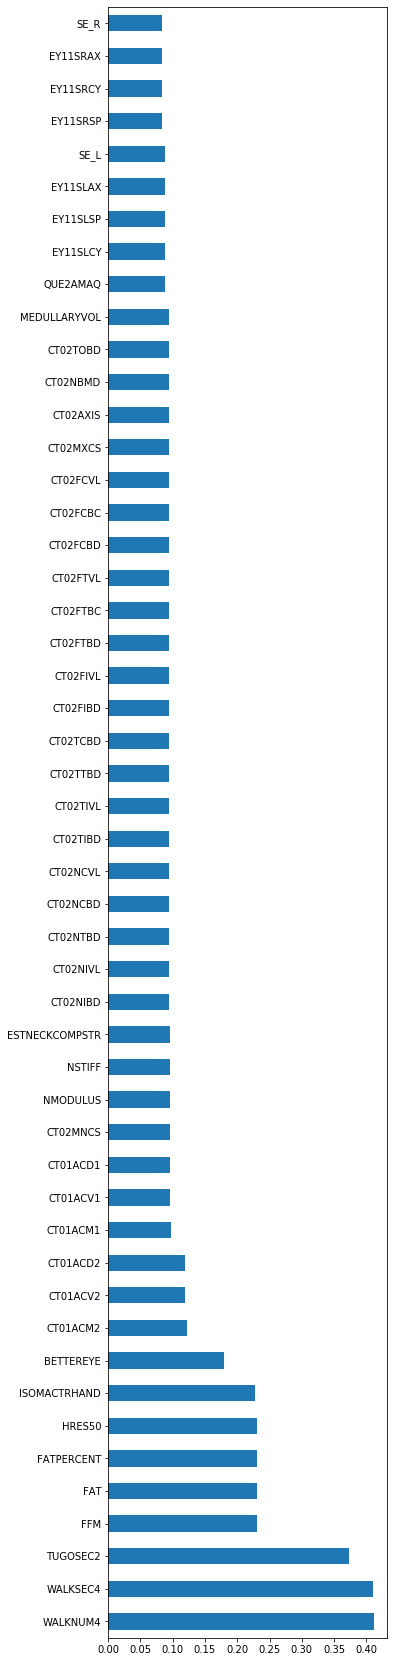

In [76]:
%matplotlib inline
fig=plt.figure(figsize=(5, 30))

AGES_data.isnull().mean().round(4).nlargest(50).plot(kind='barh')

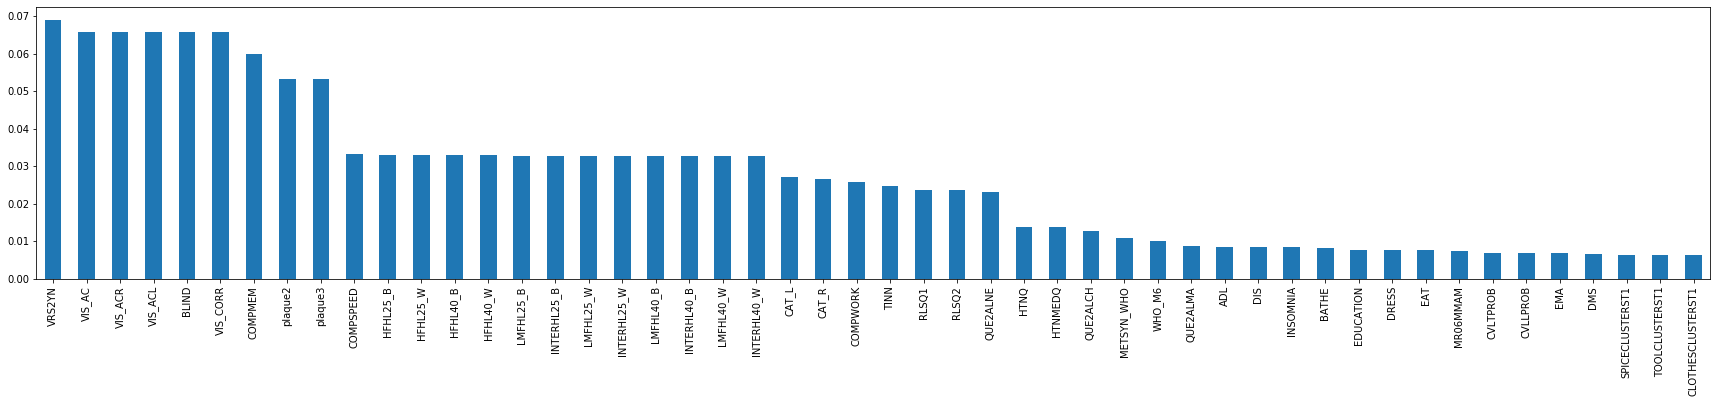

In [77]:
%matplotlib inline
fig=plt.figure(figsize=(30, 5))
AGES_data_imp.isnull().mean().round(4).nlargest(50).plot(kind='bar')

In [78]:
AGES_data.isnull().mean().round(4).nlargest(50)

WALKNUM4          0.4118
WALKSEC4          0.4098
TUGOSEC2          0.3735
FFM               0.2307
FAT               0.2307
FATPERCENT        0.2307
HRES50            0.2305
ISOMACTRHAND      0.2276
BETTEREYE         0.1800
CT01ACM2          0.1228
CT01ACV2          0.1192
CT01ACD2          0.1192
CT01ACM1          0.0975
CT01ACV1          0.0956
CT01ACD1          0.0956
CT02MNCS          0.0952
NMODULUS          0.0952
NSTIFF            0.0952
ESTNECKCOMPSTR    0.0952
CT02NIBD          0.0938
CT02NIVL          0.0938
CT02NTBD          0.0938
CT02NCBD          0.0938
CT02NCVL          0.0938
CT02TIBD          0.0938
CT02TIVL          0.0938
CT02TTBD          0.0938
CT02TCBD          0.0938
CT02FIBD          0.0938
CT02FIVL          0.0938
CT02FTBD          0.0938
CT02FTBC          0.0938
CT02FTVL          0.0938
CT02FCBD          0.0938
CT02FCBC          0.0938
CT02FCVL          0.0938
CT02MXCS          0.0938
CT02AXIS          0.0938
CT02NBMD          0.0938
CT02TOBD          0.0938


In [79]:
AGES_data_imp.isnull().mean().round(4).nlargest(20)

VRS2YN         0.0689
VIS_AC         0.0657
VIS_ACR        0.0657
VIS_ACL        0.0657
BLIND          0.0657
VIS_CORR       0.0657
COMPMEM        0.0598
plaque2        0.0533
plaque3        0.0533
COMPSPEED      0.0333
HFHL25_B       0.0329
HFHL25_W       0.0329
HFHL40_B       0.0329
HFHL40_W       0.0329
LMFHL25_B      0.0326
INTERHL25_B    0.0326
LMFHL25_W      0.0326
INTERHL25_W    0.0326
LMFHL40_B      0.0326
INTERHL40_B    0.0326
dtype: float64

In [80]:
AGES_data.shape

(4412, 714)

In [81]:
cols = AGES_data.columns[AGES_data.isnull().mean()>0.07]
AGES_data_nomissing = AGES_data.drop(cols, axis=1).dropna(axis=0, how='any', thresh=None, subset=None)
AGES_data_nomissing.shape

(2206, 647)

In [82]:
AGES_data_imp_nomissing = AGES_data_imp.dropna(axis=0, how='any', thresh=None, subset=None)
AGES_data_imp_nomissing.shape

(3116, 714)

#### Normalize the continuous/oridnal varaiables

In [83]:
scaled_AGES_data_nomissing = AGES_data_nomissing.copy()

col_names = ['AGE', 'WEIGHT', 'HEIGHT', 'ANPMMAC', 'BMI', 'HEALSTAT', 'CIMTMEAN', 'CIMTMAX', 'STIFFNESS', 'CIMTLUMEN', 'DC_KPA', 'DC_KPA2', 'ECGBM100', 'ECGBM101', 'ECGBM102', 'ECGBM111', 'ECGBM112', 'ECGBM113', 'ECGBM114', 'ECGBM115', 'ECGBM116', 'ECGBM117', 'ECGBM121', 'ECGBM122', 'ECGBM123', 'ECGBM124', 'ECGBM125', 'ECGBM126', 'ECGBM127', 'ECGBM128', 'ECGBM131', 'ECGBM132', 'ECGBM133', 'ECGBM134', 'ECGBM135', 'ECGBM136', 'ECGBM210', 'ECGBM220', 'ECGBM230', 'ECGBM240', 'ECGBM250', 'ECGBM310', 'ECGBM320', 'ECGBM330', 'ECGBM340', 'ECGBM411', 'ECGBM412', 'ECGBM420', 'ECGBM430', 'ECGBM440', 'ECGBM510', 'ECGBM520', 'ECGBM530', 'ECGBM540', 'ECGBM610', 'ECGBM621', 'ECGBM622', 'ECGBM623', 'ECGBM630', 'ECGBM641', 'ECGBM642', 'ECGBM650', 'ECGBM660', 'ECGBM680', 'ECGBM711', 'ECGBM712', 'ECGBM721', 'ECGBM722', 'ECGBM730', 'ECGBM740', 'ECGBM750', 'ECGBM760', 'ECGBM770', 'ECGBM780', 'ECGBM811', 'ECGBM812', 'ECGBM813', 'ECGBM814', 'ECGBM815', 'ECGBM821', 'ECGBM822', 'ECGBM823', 'ECGBM824', 'ECGBM831', 'ECGBM832', 'ECGBM833', 'ECGBM834', 'ECGBM841', 'ECGBM842', 'ECGBM851', 'ECGBM852', 'ECGBM861', 'ECGBM862', 'ECGBM863', 'ECGBM864', 'ECGBM870', 'ECGBM880', 'ECGBM890', 'ECGBM910', 'ECGBM920', 'ECGBM930', 'ECGBM941', 'ECGBM942', 'ECGBM950', 'ECGBM981', 'ECGBM982', 'L500', 'L1000', 'L2000', 'L3000', 'L4000', 'L6000', 'L8000', 'LC1000', 'R500', 'R1000', 'R2000', 'R3000', 'R4000', 'R6000', 'R8000', 'RC1000', 'WHO_SUM', 'TOTMETSYN', 'MICROBLD', 'FRONTAL', 'PARIETAL', 'OCCIPITAL', 'TEMPORAL', 'FRONTALR', 'PARIETALR', 'OCCIPITALR', 'TEMPORALR', 'FRONTALL', 'PARIETALL', 'OCCIPITALL', 'TEMPORALL', 'WMLLOAD', 'WMLLOADR', 'WMLLOADL', 'SCHELTENS', 'ACHTEN1', 'ACHTEN2', 'ACHTEN3', 'ACHTEN5', 'ACHTEN6', 'ACHTEN7', 'SCHELTEN2', 'CONFN', 'CONFNF', 'CONFNP', 'CONFNB', 'TOTVL', 'FRONTALVL', 'PARIETALVL', 'OCCIPITALVL', 'TEMPORALVL', 'PVSCORE', 'PVSCOREF', 'PVSCOREP', 'PVSCOREB', 'PVSCORER', 'PVSCOREL', 'BIG_MICROBLD', 'MBLPLC_1', 'MBLPLC_2', 'MBLPLC_3', 'MBLPLC_5', 'DGB_TSPN', 'DGF_TSPN', 'DSS_TCM', 'DSS_TC', 'DSS_TW', 'DSS_PCC', 'MM_SCORE', 'ST1_TIMS', 'ST1_NUMC', 'ST1_TOTC', 'ST1_TOTE', 'ST1_TFSC', 'ST2_TIMS', 'ST2_NUMC', 'ST2_TOTC', 'ST2_TOTE', 'ST2_TFSC', 'ST3_TIMS', 'ST3_NUMC', 'ST3_TOTC', 'ST3_TOTE', 'ST3_TFSC', 'FC_TOTC', 'FC_TOTE', 'FC_TOTSK', 'CVL1TOTC', 'CVL2TOTC', 'CVL3TOTC', 'CVLLTOTC', 'CVLRTOTC', 'CVL14TOT', 'CVL14LOT', 'MSWMMELA', 'MSWMSBET', 'MSWMSBE4', 'MSWMSBE6', 'MSWMSBE8', 'MSWMSWET', 'MSWMSWE4', 'MSWMSWE6', 'MSWMSWE8', 'MSWMSDET', 'MSWMSDE4', 'MSWMSDE6', 'MSWMSDE8', 'MSWMSSTR', 'MSWMSTOT2', 'ZCVLT', 'ZCVLTD', 'ZDSST', 'ZFCOMP', 'ZDIGB', 'ZDIGF', 'ZMMSE', 'ZCANTAB', 'ZSTROOP1', 'ZSTROOP2', 'ZSTROOP3', 'MEMORY', 'SPEED', 'MEMORY2', 'SPEED2', 'WORKING2', 'GDS_ANS', 'GDS_SCORE', 'GDSI_SCORE', 'CORNCAL1', 'CORNCAL2', 'ARCHCAL1', 'ARCHCAL2', 'DAORCAL1', 'DAORCAL2', 'ALLCAL1', 'ALLCAL2', 'AVGVERTCOMP', 'VBCSAL1', 'VBCSAL2', 'AVGVERTSZ', 'DCIV3', 'DCIV4', 'DEBMD2', 'DTBMD2', 'DIBMD2', 'DIBMD3', 'DTBMD3', 'APDXAL1L2', 'LATDXAL1L2', 'DCOBMD', 'MCBMD', 'TRABECULARCALCIUM', 'CORTICALCALCIUM', 'TOTALCALCIUM', 'AVGTHIM', 'AVGTHMUS', 'AVGTHSQ', 'MAFA', 'CT30LTOTAL', 'CT30LTOTALFAT', 'CT30LTOTALLEAN', 'CT30LSUBFAT', 'CT30LFASQFAT', 'CT30LTOTALMUSCLETOT', 'CT30LTOTALMUSCLEFAT', 'CT30LTOTALMUSCLELEAN', 'CT30RTOTAL', 'CT30RTOTALFAT', 'CT30RTOTALLEAN', 'CT30RSUBFAT', 'CT30RFASQFAT', 'CT30RTOTALMUSCLETOT', 'CT30RTOTALMUSCLEFAT', 'CT30RTOTALMUSCLELEAN', 'CT30LTOTALSHAFT', 'CT30LSHAFTCORT', 'CT30LSHAFTMED', 'CT31CIRC', 'CT31SAGDIAM', 'CT31TOTBODYAREA', 'CT31TOTBODYFATAREA', 'CT31TOTBODYLEANAREA', 'CT31VFFATAREA', 'CT31SQFATAREA', 'PIXIBMD', 'TUGOSEC1', 'WALKSEC1', 'WALKNUM1', 'WALKSEC2', 'WALKNUM2', 'STEPS_NORMAL', 'TIME_NORMAL', 'S_CHOL', 'S_HDLC2', 'S_LDL', 'S_TG', 'S_GLU', 'S_CRP_S', 'S_INSULIN', 'COUNTMIGR', 'QUE2ALEV', 'DSS_CUTOFF', 'MM_CUTOFF', 'S_AL_KR', 'S_BA_N', 'S_BA_PCT', 'S_CRE_S', 's_standardized_CREA_S', 'S_CRE_U', 'S_EO_N', 'S_EO_PCT', 'S_HCT', 'S_HGB', 'S_LY_N', 'S_LY_PCT', 'S_M_ALB', 'S_MCH', 'S_MCHC', 'S_MCV', 'S_MO_N', 'S_MO_PCT', 'S_MPV', 'S_NE_N', 'S_NE_PCT', 'S_PCT', 'S_PDW', 'S_PLT', 'S_RBC', 'S_RDW', 'S_U_E', 'S_U_GLUK', 'S_U_HBK', 'S_U_NIT', 'S_U_PROT', 'S_U_RBK', 'S_U_PH', 'S_UA', 'S_WBC', 'CHOL', 'GLU', 'HGB', 'INSULIN', 'PLT', 'TG', 'UA', 'LDL', 'HDLC2', 'RBC', 'WBC', 'BA_pct', 'EO_pct', 'MO_pct', 'NE_pct', 'LY_pct', 'MCH', 'MCHC', 'MCV', 'U_GLUK', 'U_pH', 'U_PROT', 'CRE_S', 'standardized_CREA_S', 'CRE_U', 'VA_INIR', 'VA_INIL', 'VA_BETT', 'VA_WORS', 'VA_BCR', 'VA_BCL', 'VA_BCB', 'VA_BCW', 'leisure', 'leisure_men', 'leisure_soc', 'leisure2', 'leisure_men2', 'leisure_soc2', 'BLPRMIL', 'SYS', 'DID', 'PULSEPRESSURE', 'MAP', 'plaq_max', 'plaq_n', 'nmed', 'diabetesMedcount', 'dmmedinsulincount', 'dmmedoralcount', 'cholmedcount', 'bblockercount', 'statinscount', 'PACKAYEAR', 'CIGARAYEAR', 'CHEWAYEAR', 'PACK_YEARS', 'CIGAR_YEARS', 'CHEW_YEARS', 'C_YEAR', 'p_YEAR', 'CH_YEAR', 'dmmed', 'NMPAN', 'OMPAN', 'MMPAN', 'YMPAN', 'physactivpres', 'walktime_wh', 'walktime_Sh', 'swimtime_wh', 'swimtime_Sh', 'walk_w_cat', 'walk_s_cat', 'walktime_ay', 'walk_ay_cat', 'swim_w_cat', 'swim_s_cat', 'swim_ay_cat', 'QUE2ALHO', 'QUE2ALHM', 'QUE2AMAO', 'alcoholgweek', 'alcoholgweek_mid', 'TOTAL_BRAIN']
features = scaled_AGES_data_nomissing[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_AGES_data_nomissing[col_names] = features

scaled_AGES_data_nomissing.head()

,AGE,SEX,EDUCATION,WEIGHT,HEIGHT,ANPMMAC,BMI,HEALSTAT,CIMTMEAN,CIMTMAX,STIFFNESS,CIMTLUMEN,DC_KPA,DC_KPA2,ECGBM100,ECGBM101,ECGBM102,ECGBM111,ECGBM112,ECGBM113,ECGBM114,ECGBM115,ECGBM116,ECGBM117,ECGBM121,ECGBM122,ECGBM123,ECGBM124,ECGBM125,ECGBM126,ECGBM127,ECGBM128,ECGBM131,ECGBM132,ECGBM133,ECGBM134,ECGBM135,ECGBM136,ECGBM210,ECGBM220,ECGBM230,ECGBM240,ECGBM250,ECGBM310,ECGBM320,ECGBM330,ECGBM340,ECGBM411,ECGBM412,ECGBM420,ECGBM430,ECGBM440,ECGBM510,ECGBM520,ECGBM530,ECGBM540,ECGBM610,ECGBM621,ECGBM622,ECGBM623,ECGBM630,ECGBM641,ECGBM642,ECGBM650,ECGBM660,ECGBM680,ECGBM711,ECGBM712,ECGBM721,ECGBM722,ECGBM730,ECGBM740,ECGBM750,ECGBM760,ECGBM770,ECGBM780,ECGBM811,ECGBM812,ECGBM813,ECGBM814,ECGBM815,ECGBM821,ECGBM822,ECGBM823,ECGBM824,ECGBM831,ECGBM832,ECGBM833,ECGBM834,ECGBM841,ECGBM842,ECGBM851,ECGBM852,ECGBM861,ECGBM862,ECGBM863,ECGBM864,ECGBM870,ECGBM880,ECGBM890,ECGBM910,ECGBM920,ECGBM930,ECGBM941,ECGBM942,ECGBM950,ECGBM981,ECGBM982,MI_ECG,TINN,L500,L1000,L2000,L3000,L4000,L6000,L8000,LC1000,R500,R1000,R2000,R3000,R4000,R6000,R8000,RC1000,LMFHL25_B,HFHL25_B,INTERHL25_B,LMFHL25_W,HFHL25_W,INTERHL25_W,LMFHL40_B,HFHL40_B,INTERHL40_B,LMFHL40_W,HFHL40_W,INTERHL40_W,WHO_M1,WHO_M2,WHO_M3,WHO_M4,WHO_M5,WHO_M6,WHO_SUM,METSYN_WHO,METSYN,M1,M2,M3,M4,M5,TOTMETSYN,MICROBLD,FRONTAL,PARIETAL,OCCIPITAL,TEMPORAL,FRONTALR,PARIETALR,OCCIPITALR,TEMPORALR,FRONTALL,PARIETALL,OCCIPITALL,TEMPORALL,WMLLOAD,WMLLOADR,WMLLOADL,SCHELTENS,ACHTEN1,ACHTEN2,ACHTEN3,ACHTEN5,ACHTEN6,ACHTEN7,SCHELTEN2,ACHTEN4,ACHTEN8,ACHTEN9,CONFN,CONFNF,CONFNP,CONFNB,TOTVL,FRONTALVL,PARIETALVL,OCCIPITALVL,TEMPORALVL,PVSCORE,PVSCOREF,PVSCOREP,PVSCOREB,PVSCORER,PVSCOREL,SUBCORTYN,VRSYN,VRS2YN,SCVRSYN,INFARCTYN,INFCORTYN,INFCERYN,BIG_MICROBLD,MBLPLC_1,MBLPLC_2,MBLPLC_3,MBLPLC_5,DGB_TSPN,DGB_PROB,DGF_TSPN,DGF_PROB,DSS_TCM,DSS_TC,DSS_TW,DSS_PCC,DSS_PROB,MM_SCORE,ME_PROB,ST1_TIMS,ST1_NUMC,ST1_TOTC,ST1_TOTE,ST1_TFSC,STP_PROB,ST2_TIMS,ST2_NUMC,ST2_TOTC,ST2_TOTE,ST2_TFSC,ST3_TIMS,ST3_NUMC,ST3_TOTC,ST3_TOTE,ST3_TFSC,FC_TOTC,FC_TOTE,FC_TOTSK,FC_PROB,CVL1TOTC,CVL2TOTC,CVL3TOTC,CVL4TOTC,CVLLTOTC,CVLRTOTC,CVL14TOT,CVL14LOT,CVLTPROB,CVLLPROB,MSWMMELA,MSWMSBET,MSWMSBE4,MSWMSBE6,MSWMSBE8,MSWMSWET,MSWMSWE4,MSWMSWE6,MSWMSWE8,MSWMSDET,MSWMSDE4,MSWMSDE6,MSWMSDE8,MSWMSSTR,MSWMSTOT2,MSW2PRO1,MSW2PRO2,SPICECLUSTERST1,TOOLCLUSTERST1,CLOTHESCLUSTERST1,FRUITCLUSTERST1,SPICECLUSTERST2,TOOLCLUSTERST2,CLOTHESCLUSTERST2,FRUITCLUSTERST2,SPICECLUSTERST3,TOOLCLUSTERST3,CLOTHESCLUSTERST3,FRUITCLUSTERST3,SPICECLUSTERST4,TOOLCLUSTERST4,CLOTHESCLUSTERST4,FRUITCLUSTERST4,SPICECLUSTERSTL,TOOLCLUSTERSTL,CLOTHESCLUSTERSTL,FRUITCLUSTERSTL,ZCVLT,ZCVLTD,ZDSST,ZFCOMP,ZDIGB,ZDIGF,ZMMSE,ZCANTAB,ZSTROOP1,ZSTROOP2,ZSTROOP3,MEMORY,WORKING,SPEED,MEMORY2,SPEED2,WORKING2,COMPMEM,COMPWORK,COMPSPEED,GDS_ANS,GDS_SCORE,GDSI_SCORE,CORNCAL1,CORNCAL2,ARCHCAL1,ARCHCAL2,DAORCAL1,DAORCAL2,ALLCAL1,ALLCAL2,AVGVERTCOMP,VBCSAL1,VBCSAL2,AVGVERTSZ,DCIV3,DCIV4,DEBMD2,DTBMD2,DIBMD2,DIBMD3,DTBMD3,APDXAL1L2,LATDXAL1L2,DCOBMD,MCBMD,TRABECULARCALCIUM,CORTICALCALCIUM,TOTALCALCIUM,AVGTHIM,AVGTHMUS,AVGTHSQ,MAFA,CT30LTOTAL,CT30LTOTALFAT,CT30LTOTALLEAN,CT30LSUBFAT,CT30LFASQFAT,CT30LTOTALMUSCLETOT,CT30LTOTALMUSCLEFAT,CT30LTOTALMUSCLELEAN,CT30RTOTAL,CT30RTOTALFAT,CT30RTOTALLEAN,CT30RSUBFAT,CT30RFASQFAT,CT30RTOTALMUSCLETOT,CT30RTOTALMUSCLEFAT,CT30RTOTALMUSCLELEAN,CT30LTOTALSHAFT,CT30LSHAFTCORT,CT30LSHAFTMED,CT31CIRC,CT31SAGDIAM,CT31TOTBODYAREA,CT31TOTBODYFATAREA,CT31TOTBODYLEANAREA,CT31VFFATAREA,CT31SQFATAREA,PIXIBMD,TUGOSEC1,WALKSEC1,WALKNUM1,WALKSEC2,WALKNUM2,STEPS_NORMAL,TIME_NORMAL,S_CHOL,S_HDLC2,S_LDL,S_TG,S_GLU,S_CRP_S,S_INSULIN,HTNMED,DRESS,BATHE,TRANSFER,EAT,WALK,ADL,HEALHTN1,HEALHTN2,HEALHTN3,HEALHTN4,HEALH401,HEALH402,HEALH403,HEALH404,DIS,DMS,EMA,INSOMNIA,MIGRA,MIGRA_DX,COUNTMIGR,QUE2ALEV,PASSDSST,PASSMMSE,PASSCOG1,PASSDSST_S,PASSMMSE_S,PASSCOG1_S,DSS_CUTOFF,MM_CUTOFF,RLSQ1,RLSQ2,S_AL_KR,S_BA_N,S_BA_PCT,S_CRE_S,s_standardized_CREA_S,S_CRE_U,S_EO_N,S_EO_PCT,S_HCT,S_HGB,S_LY_N,S_LY_PCT,S_M_ALB,S_MCH,S_MCHC,S_MCV,S_MO_N,S_MO_PCT,S_MPV,S_NE_N,S_NE_

In [84]:
scaled_AGES_data_nomissing.describe()

,AGE,SEX,EDUCATION,WEIGHT,HEIGHT,ANPMMAC,BMI,HEALSTAT,CIMTMEAN,CIMTMAX,STIFFNESS,CIMTLUMEN,DC_KPA,DC_KPA2,ECGBM100,ECGBM101,ECGBM102,ECGBM111,ECGBM112,ECGBM113,ECGBM114,ECGBM115,ECGBM116,ECGBM117,ECGBM121,ECGBM122,ECGBM123,ECGBM124,ECGBM125,ECGBM126,ECGBM127,ECGBM128,ECGBM131,ECGBM132,ECGBM133,ECGBM134,ECGBM135,ECGBM136,ECGBM210,ECGBM220,ECGBM230,ECGBM240,ECGBM250,ECGBM310,ECGBM320,ECGBM330,ECGBM340,ECGBM411,ECGBM412,ECGBM420,ECGBM430,ECGBM440,ECGBM510,ECGBM520,ECGBM530,ECGBM540,ECGBM610,ECGBM621,ECGBM622,ECGBM623,ECGBM630,ECGBM641,ECGBM642,ECGBM650,ECGBM660,ECGBM680,ECGBM711,ECGBM712,ECGBM721,ECGBM722,ECGBM730,ECGBM740,ECGBM750,ECGBM760,ECGBM770,ECGBM780,ECGBM811,ECGBM812,ECGBM813,ECGBM814,ECGBM815,ECGBM821,ECGBM822,ECGBM823,ECGBM824,ECGBM831,ECGBM832,ECGBM833,ECGBM834,ECGBM841,ECGBM842,ECGBM851,ECGBM852,ECGBM861,ECGBM862,ECGBM863,ECGBM864,ECGBM870,ECGBM880,ECGBM890,ECGBM910,ECGBM920,ECGBM930,ECGBM941,ECGBM942,ECGBM950,ECGBM981,ECGBM982,MI_ECG,TINN,L500,L1000,L2000,L3000,L4000,L6000,L8000,LC1000,R500,R1000,R2000,R3000,R4000,R6000,R8000,RC1000,LMFHL25_B,HFHL25_B,INTERHL25_B,LMFHL25_W,HFHL25_W,INTERHL25_W,LMFHL40_B,HFHL40_B,INTERHL40_B,LMFHL40_W,HFHL40_W,INTERHL40_W,WHO_M1,WHO_M2,WHO_M3,WHO_M4,WHO_M5,WHO_M6,WHO_SUM,METSYN_WHO,METSYN,M1,M2,M3,M4,M5,TOTMETSYN,MICROBLD,FRONTAL,PARIETAL,OCCIPITAL,TEMPORAL,FRONTALR,PARIETALR,OCCIPITALR,TEMPORALR,FRONTALL,PARIETALL,OCCIPITALL,TEMPORALL,WMLLOAD,WMLLOADR,WMLLOADL,SCHELTENS,ACHTEN1,ACHTEN2,ACHTEN3,ACHTEN5,ACHTEN6,ACHTEN7,SCHELTEN2,ACHTEN4,ACHTEN8,ACHTEN9,CONFN,CONFNF,CONFNP,CONFNB,TOTVL,FRONTALVL,PARIETALVL,OCCIPITALVL,TEMPORALVL,PVSCORE,PVSCOREF,PVSCOREP,PVSCOREB,PVSCORER,PVSCOREL,SUBCORTYN,VRSYN,VRS2YN,SCVRSYN,INFARCTYN,INFCORTYN,INFCERYN,BIG_MICROBLD,MBLPLC_1,MBLPLC_2,MBLPLC_3,MBLPLC_5,DGB_TSPN,DGB_PROB,DGF_TSPN,DGF_PROB,DSS_TCM,DSS_TC,DSS_TW,DSS_PCC,DSS_PROB,MM_SCORE,ME_PROB,ST1_TIMS,ST1_NUMC,ST1_TOTC,ST1_TOTE,ST1_TFSC,STP_PROB,ST2_TIMS,ST2_NUMC,ST2_TOTC,ST2_TOTE,ST2_TFSC,ST3_TIMS,ST3_NUMC,ST3_TOTC,ST3_TOTE,ST3_TFSC,FC_TOTC,FC_TOTE,FC_TOTSK,FC_PROB,CVL1TOTC,CVL2TOTC,CVL3TOTC,CVL4TOTC,CVLLTOTC,CVLRTOTC,CVL14TOT,CVL14LOT,CVLTPROB,CVLLPROB,MSWMMELA,MSWMSBET,MSWMSBE4,MSWMSBE6,MSWMSBE8,MSWMSWET,MSWMSWE4,MSWMSWE6,MSWMSWE8,MSWMSDET,MSWMSDE4,MSWMSDE6,MSWMSDE8,MSWMSSTR,MSWMSTOT2,MSW2PRO1,MSW2PRO2,SPICECLUSTERST1,TOOLCLUSTERST1,CLOTHESCLUSTERST1,FRUITCLUSTERST1,SPICECLUSTERST2,TOOLCLUSTERST2,CLOTHESCLUSTERST2,FRUITCLUSTERST2,SPICECLUSTERST3,TOOLCLUSTERST3,CLOTHESCLUSTERST3,FRUITCLUSTERST3,SPICECLUSTERST4,TOOLCLUSTERST4,CLOTHESCLUSTERST4,FRUITCLUSTERST4,SPICECLUSTERSTL,TOOLCLUSTERSTL,CLOTHESCLUSTERSTL,FRUITCLUSTERSTL,ZCVLT,ZCVLTD,ZDSST,ZFCOMP,ZDIGB,ZDIGF,ZMMSE,ZCANTAB,ZSTROOP1,ZSTROOP2,ZSTROOP3,MEMORY,WORKING,SPEED,MEMORY2,SPEED2,WORKING2,COMPMEM,COMPWORK,COMPSPEED,GDS_ANS,GDS_SCORE,GDSI_SCORE,CORNCAL1,CORNCAL2,ARCHCAL1,ARCHCAL2,DAORCAL1,DAORCAL2,ALLCAL1,ALLCAL2,AVGVERTCOMP,VBCSAL1,VBCSAL2,AVGVERTSZ,DCIV3,DCIV4,DEBMD2,DTBMD2,DIBMD2,DIBMD3,DTBMD3,APDXAL1L2,LATDXAL1L2,DCOBMD,MCBMD,TRABECULARCALCIUM,CORTICALCALCIUM,TOTALCALCIUM,AVGTHIM,AVGTHMUS,AVGTHSQ,MAFA,CT30LTOTAL,CT30LTOTALFAT,CT30LTOTALLEAN,CT30LSUBFAT,CT30LFASQFAT,CT30LTOTALMUSCLETOT,CT30LTOTALMUSCLEFAT,CT30LTOTALMUSCLELEAN,CT30RTOTAL,CT30RTOTALFAT,CT30RTOTALLEAN,CT30RSUBFAT,CT30RFASQFAT,CT30RTOTALMUSCLETOT,CT30RTOTALMUSCLEFAT,CT30RTOTALMUSCLELEAN,CT30LTOTALSHAFT,CT30LSHAFTCORT,CT30LSHAFTMED,CT31CIRC,CT31SAGDIAM,CT31TOTBODYAREA,CT31TOTBODYFATAREA,CT31TOTBODYLEANAREA,CT31VFFATAREA,CT31SQFATAREA,PIXIBMD,TUGOSEC1,WALKSEC1,WALKNUM1,WALKSEC2,WALKNUM2,STEPS_NORMAL,TIME_NORMAL,S_CHOL,S_HDLC2,S_LDL,S_TG,S_GLU,S_CRP_S,S_INSULIN,HTNMED,DRESS,BATHE,TRANSFER,EAT,WALK,ADL,HEALHTN1,HEALHTN2,HEALHTN3,HEALHTN4,HEALH401,HEALH402,HEALH403,HEALH404,DIS,DMS,EMA,INSOMNIA,MIGRA,MIGRA_DX,COUNTMIGR,QUE2ALEV,PASSDSST,PASSMMSE,PASSCOG1,PASSDSST_S,PASSMMSE_S,PASSCOG1_S,DSS_CUTOFF,MM_CUTOFF,RLSQ1,RLSQ2,S_AL_KR,S_BA_N,S_BA_PCT,S_CRE_S,s_standardized_CREA_S,S_CRE_U,S_EO_N,S_EO_PCT,S_HCT,S_HGB,S_LY_N,S_LY_PCT,S_M_ALB,S_MCH,S_MCHC,S_MCV,S_MO_N,S_MO_PCT,S_MPV,S_NE_N,S_NE_

In [85]:
scaled_AGES_data_imp_nomissing = AGES_data_imp_nomissing.copy()

col_names = ['AGE', 'WEIGHT', 'HEIGHT', 'ANPMMAC', 'BMI', 'HRES50', 'FFM', 'FAT', 'FATPERCENT', 'HEALSTAT', 'CIMTMEAN', 'CIMTMAX', 'STIFFNESS', 'CIMTLUMEN', 'DC_KPA', 'DC_KPA2', 'ECGBM100', 'ECGBM101', 'ECGBM102', 'ECGBM111', 'ECGBM112', 'ECGBM113', 'ECGBM114', 'ECGBM115', 'ECGBM116', 'ECGBM117', 'ECGBM121', 'ECGBM122', 'ECGBM123', 'ECGBM124', 'ECGBM125', 'ECGBM126', 'ECGBM127', 'ECGBM128', 'ECGBM131', 'ECGBM132', 'ECGBM133', 'ECGBM134', 'ECGBM135', 'ECGBM136', 'ECGBM210', 'ECGBM220', 'ECGBM230', 'ECGBM240', 'ECGBM250', 'ECGBM310', 'ECGBM320', 'ECGBM330', 'ECGBM340', 'ECGBM411', 'ECGBM412', 'ECGBM420', 'ECGBM430', 'ECGBM440', 'ECGBM510', 'ECGBM520', 'ECGBM530', 'ECGBM540', 'ECGBM610', 'ECGBM621', 'ECGBM622', 'ECGBM623', 'ECGBM630', 'ECGBM641', 'ECGBM642', 'ECGBM650', 'ECGBM660', 'ECGBM680', 'ECGBM711', 'ECGBM712', 'ECGBM721', 'ECGBM722', 'ECGBM730', 'ECGBM740', 'ECGBM750', 'ECGBM760', 'ECGBM770', 'ECGBM780', 'ECGBM811', 'ECGBM812', 'ECGBM813', 'ECGBM814', 'ECGBM815', 'ECGBM821', 'ECGBM822', 'ECGBM823', 'ECGBM824', 'ECGBM831', 'ECGBM832', 'ECGBM833', 'ECGBM834', 'ECGBM841', 'ECGBM842', 'ECGBM851', 'ECGBM852', 'ECGBM861', 'ECGBM862', 'ECGBM863', 'ECGBM864', 'ECGBM870', 'ECGBM880', 'ECGBM890', 'ECGBM910', 'ECGBM920', 'ECGBM930', 'ECGBM941', 'ECGBM942', 'ECGBM950', 'ECGBM981', 'ECGBM982', 'L500', 'L1000', 'L2000', 'L3000', 'L4000', 'L6000', 'L8000', 'LC1000', 'R500', 'R1000', 'R2000', 'R3000', 'R4000', 'R6000', 'R8000', 'RC1000', 'WHO_SUM', 'TOTMETSYN', 'MICROBLD', 'FRONTAL', 'PARIETAL', 'OCCIPITAL', 'TEMPORAL', 'FRONTALR', 'PARIETALR', 'OCCIPITALR', 'TEMPORALR', 'FRONTALL', 'PARIETALL', 'OCCIPITALL', 'TEMPORALL', 'WMLLOAD', 'WMLLOADR', 'WMLLOADL', 'SCHELTENS', 'ACHTEN1', 'ACHTEN2', 'ACHTEN3', 'ACHTEN5', 'ACHTEN6', 'ACHTEN7', 'SCHELTEN2', 'CONFN', 'CONFNF', 'CONFNP', 'CONFNB', 'TOTVL', 'FRONTALVL', 'PARIETALVL', 'OCCIPITALVL', 'TEMPORALVL', 'PVSCORE', 'PVSCOREF', 'PVSCOREP', 'PVSCOREB', 'PVSCORER', 'PVSCOREL', 'BIG_MICROBLD', 'MBLPLC_1', 'MBLPLC_2', 'MBLPLC_3', 'MBLPLC_5', 'DGB_TSPN', 'DGF_TSPN', 'DSS_TCM', 'DSS_TC', 'DSS_TW', 'DSS_PCC', 'MM_SCORE', 'ST1_TIMS', 'ST1_NUMC', 'ST1_TOTC', 'ST1_TOTE', 'ST1_TFSC', 'ST2_TIMS', 'ST2_NUMC', 'ST2_TOTC', 'ST2_TOTE', 'ST2_TFSC', 'ST3_TIMS', 'ST3_NUMC', 'ST3_TOTC', 'ST3_TOTE', 'ST3_TFSC', 'FC_TOTC', 'FC_TOTE', 'FC_TOTSK', 'CVL1TOTC', 'CVL2TOTC', 'CVL3TOTC', 'CVL4TOTC', 'CVLLTOTC', 'CVLRTOTC', 'CVL14TOT', 'CVL14LOT', 'MSWMMELA', 'MSWMSBET', 'MSWMSBE4', 'MSWMSBE6', 'MSWMSBE8', 'MSWMSWET', 'MSWMSWE4', 'MSWMSWE6', 'MSWMSWE8', 'MSWMSDET', 'MSWMSDE4', 'MSWMSDE6', 'MSWMSDE8', 'MSWMSSTR', 'MSWMSTOT2', 'ZCVLT', 'ZCVLTD', 'ZDSST', 'ZFCOMP', 'ZDIGB', 'ZDIGF', 'ZMMSE', 'ZCANTAB', 'ZSTROOP1', 'ZSTROOP2', 'ZSTROOP3', 'MEMORY', 'WORKING', 'SPEED', 'MEMORY2', 'SPEED2', 'WORKING2', 'GDS_ANS', 'GDS_SCORE', 'GDSI_SCORE', 'CORNCAL1', 'CORNCAL2', 'ARCHCAL1', 'ARCHCAL2', 'DAORCAL1', 'DAORCAL2', 'ALLCAL1', 'ALLCAL2', 'CT01ACV1', 'CT01ACM1', 'CT01ACD1', 'CT01ACV2', 'CT01ACM2', 'CT01ACD2', 'AVGVERTCOMP', 'VBCSAL1', 'VBCSAL2', 'AVGVERTSZ', 'DCIV3', 'DCIV4', 'DEBMD2', 'DTBMD2', 'DIBMD2', 'DIBMD3', 'DTBMD3', 'APDXAL1L2', 'LATDXAL1L2', 'DCOBMD', 'MCBMD', 'TRABECULARCALCIUM', 'CORTICALCALCIUM', 'TOTALCALCIUM', 'CT02NIBD', 'CT02NIVL', 'CT02NTBD', 'CT02NCBD', 'CT02NCVL', 'CT02TIBD', 'CT02TIVL', 'CT02TTBD', 'CT02TCBD', 'CT02FIBD', 'CT02FIVL', 'CT02FTBD', 'CT02FTBC', 'CT02FTVL', 'CT02FCBD', 'CT02FCBC', 'CT02FCVL', 'CT02MNCS', 'CT02MXCS', 'CT02AXIS', 'CT02NBMD', 'CT02TOBD', 'NMODULUS', 'NSTIFF', 'MEDULLARYVOL', 'ESTNECKCOMPSTR', 'AVGTHIM', 'AVGTHMUS', 'AVGTHSQ', 'MAFA', 'CT30LTOTAL', 'CT30LTOTALFAT', 'CT30LTOTALLEAN', 'CT30LSUBFAT', 'CT30LFASQFAT', 'CT30LTOTALMUSCLETOT', 'CT30LTOTALMUSCLEFAT', 'CT30LTOTALMUSCLELEAN', 'CT30RTOTAL', 'CT30RTOTALFAT', 'CT30RTOTALLEAN', 'CT30RSUBFAT', 'CT30RFASQFAT', 'CT30RTOTALMUSCLETOT', 'CT30RTOTALMUSCLEFAT', 'CT30RTOTALMUSCLELEAN', 'CT30LTOTALSHAFT', 'CT30LSHAFTCORT', 'CT30LSHAFTMED', 'CT31CIRC', 'CT31SAGDIAM', 'CT31TOTBODYAREA', 'CT31TOTBODYFATAREA', 'CT31TOTBODYLEANAREA', 'CT31VFFATAREA', 'CT31SQFATAREA', 'PIXIBMD', 'TUGOSEC1', 'TUGOSEC2', 'WALKSEC1', 'WALKNUM1', 'WALKSEC2', 'WALKNUM2', 'WALKSEC3', 'WALKNUM3', 'WALKSEC4', 'WALKNUM4', 'STEPS_NORMAL', 'STEPS_FAST', 'TIME_NORMAL', 'TIME_FAST', 'ISOMMASTLEG', 'ISOMACTRLEG', 'LEGSTRNM', 'LWRLEGLTH', 'ISOMMASTHAND', 'ISOMACTRHAND', 'S_CHOL', 'S_HDLC2', 'S_LDL', 'S_TG', 'S_GLU', 'S_HBA1C', 'S_HBA1', 'S_CRP_S', 'S_INSULIN', 'COUNTMIGR', 'BETTEREYE', 'QUE2ALEV', 'DSS_CUTOFF', 'MM_CUTOFF', 'S_AL_KR', 'S_BA_N', 'S_BA_PCT', 'S_CRE_S', 's_standardized_CREA_S', 'S_CRE_U', 'S_EO_N', 'S_EO_PCT', 'S_HB', 'S_HCT', 'S_HGB', 'S_LY_N', 'S_LY_PCT', 'S_M_ALB', 'S_MCH', 'S_MCHC', 'S_MCV', 'S_MO_N', 'S_MO_PCT', 'S_MPV', 'S_NE_N', 'S_NE_PCT', 'S_PCT', 'S_PDW', 'S_PLT', 'S_RBC', 'S_RDW', 'S_U_E', 'S_U_GLUK', 'S_U_HBK', 'S_U_NIT', 'S_U_PROT', 'S_U_RBK', 'S_U_PH', 'S_UA', 'S_WBC', 'CHOL', 'GLU', 'HGB', 'INSULIN', 'PLT', 'TG', 'UA', 'LDL', 'HDLC2', 'RBC', 'WBC', 'BA_pct', 'EO_pct', 'MO_pct', 'NE_pct', 'LY_pct', 'MCH', 'MCHC', 'MCV', 'U_GLUK', 'U_pH', 'U_PROT', 'CRE_S', 'standardized_CREA_S', 'CRE_U', 'VA_INIR', 'VA_INIL', 'VA_BETT', 'VA_WORS', 'VA_BCR', 'VA_BCL', 'VA_BCB', 'VA_BCW', 'EY11SLSP', 'EY11SLCY', 'EY11SLAX', 'EY11SRSP', 'EY11SRCY', 'EY11SRAX', 'SE_L', 'SE_R', 'SE_MEAN', 'SE_B', 'SE_W', 'leisure', 'leisure_men', 'leisure_soc', 'leisure2', 'leisure_men2', 'leisure_soc2', 'BLPRMIL', 'SYS', 'DID', 'PULSEPRESSURE', 'MAP', 'plaq_max', 'plaq_n', 'nmed', 'diabetesMedcount', 'dmmedinsulincount', 'dmmedoralcount', 'cholmedcount', 'bblockercount', 'statinscount', 'PACKAYEAR', 'CIGARAYEAR', 'CHEWAYEAR', 'PACK_YEARS', 'CIGAR_YEARS', 'CHEW_YEARS', 'C_YEAR', 'p_YEAR', 'CH_YEAR', 'dmmed', 'NMPAN', 'OMPAN', 'MMPAN', 'YMPAN', 'lifpatot', 'physactivpast', 'physactivpres', 'allPA', 'physactivall', 'walktime_wh', 'walktime_Sh', 'swimtime_wh', 'swimtime_Sh', 'walk_w_cat', 'walk_s_cat', 'walktime_ay', 'walk_ay_cat', 'swim_w_cat', 'swim_s_cat', 'swim_ay_cat', 'QUE2ALHO', 'QUE2ALHM', 'QUE2AMAO', 'QUE2AMAQ', 'alcoholgweek', 'alcoholgweek_mid', 'TOTAL_BRAIN']
features = scaled_AGES_data_imp_nomissing[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_AGES_data_imp_nomissing[col_names] = features

scaled_AGES_data_imp_nomissing.head()

,AGE,SEX,EDUCATION,WEIGHT,HEIGHT,ANPMMAC,BMI,HRES50,FFM,FAT,FATPERCENT,HEALSTAT,CIMTMEAN,CIMTMAX,STIFFNESS,CIMTLUMEN,DC_KPA,DC_KPA2,ECGBM100,ECGBM101,ECGBM102,ECGBM111,ECGBM112,ECGBM113,ECGBM114,ECGBM115,ECGBM116,ECGBM117,ECGBM121,ECGBM122,ECGBM123,ECGBM124,ECGBM125,ECGBM126,ECGBM127,ECGBM128,ECGBM131,ECGBM132,ECGBM133,ECGBM134,ECGBM135,ECGBM136,ECGBM210,ECGBM220,ECGBM230,ECGBM240,ECGBM250,ECGBM310,ECGBM320,ECGBM330,ECGBM340,ECGBM411,ECGBM412,ECGBM420,ECGBM430,ECGBM440,ECGBM510,ECGBM520,ECGBM530,ECGBM540,ECGBM610,ECGBM621,ECGBM622,ECGBM623,ECGBM630,ECGBM641,ECGBM642,ECGBM650,ECGBM660,ECGBM680,ECGBM711,ECGBM712,ECGBM721,ECGBM722,ECGBM730,ECGBM740,ECGBM750,ECGBM760,ECGBM770,ECGBM780,ECGBM811,ECGBM812,ECGBM813,ECGBM814,ECGBM815,ECGBM821,ECGBM822,ECGBM823,ECGBM824,ECGBM831,ECGBM832,ECGBM833,ECGBM834,ECGBM841,ECGBM842,ECGBM851,ECGBM852,ECGBM861,ECGBM862,ECGBM863,ECGBM864,ECGBM870,ECGBM880,ECGBM890,ECGBM910,ECGBM920,ECGBM930,ECGBM941,ECGBM942,ECGBM950,ECGBM981,ECGBM982,MI_ECG,TINN,L500,L1000,L2000,L3000,L4000,L6000,L8000,LC1000,R500,R1000,R2000,R3000,R4000,R6000,R8000,RC1000,LMFHL25_B,HFHL25_B,INTERHL25_B,LMFHL25_W,HFHL25_W,INTERHL25_W,LMFHL40_B,HFHL40_B,INTERHL40_B,LMFHL40_W,HFHL40_W,INTERHL40_W,WHO_M1,WHO_M2,WHO_M3,WHO_M4,WHO_M5,WHO_M6,WHO_SUM,METSYN_WHO,METSYN,M1,M2,M3,M4,M5,TOTMETSYN,MICROBLD,FRONTAL,PARIETAL,OCCIPITAL,TEMPORAL,FRONTALR,PARIETALR,OCCIPITALR,TEMPORALR,FRONTALL,PARIETALL,OCCIPITALL,TEMPORALL,WMLLOAD,WMLLOADR,WMLLOADL,SCHELTENS,ACHTEN1,ACHTEN2,ACHTEN3,ACHTEN5,ACHTEN6,ACHTEN7,SCHELTEN2,ACHTEN4,ACHTEN8,ACHTEN9,CONFN,CONFNF,CONFNP,CONFNB,TOTVL,FRONTALVL,PARIETALVL,OCCIPITALVL,TEMPORALVL,PVSCORE,PVSCOREF,PVSCOREP,PVSCOREB,PVSCORER,PVSCOREL,SUBCORTYN,VRSYN,VRS2YN,SCVRSYN,INFARCTYN,INFCORTYN,INFCERYN,BIG_MICROBLD,MBLPLC_1,MBLPLC_2,MBLPLC_3,MBLPLC_5,DGB_TSPN,DGB_PROB,DGF_TSPN,DGF_PROB,DSS_TCM,DSS_TC,DSS_TW,DSS_PCC,DSS_PROB,MM_SCORE,ME_PROB,ST1_TIMS,ST1_NUMC,ST1_TOTC,ST1_TOTE,ST1_TFSC,STP_PROB,ST2_TIMS,ST2_NUMC,ST2_TOTC,ST2_TOTE,ST2_TFSC,ST3_TIMS,ST3_NUMC,ST3_TOTC,ST3_TOTE,ST3_TFSC,FC_TOTC,FC_TOTE,FC_TOTSK,FC_PROB,CVL1TOTC,CVL2TOTC,CVL3TOTC,CVL4TOTC,CVLLTOTC,CVLRTOTC,CVL14TOT,CVL14LOT,CVLTPROB,CVLLPROB,MSWMMELA,MSWMSBET,MSWMSBE4,MSWMSBE6,MSWMSBE8,MSWMSWET,MSWMSWE4,MSWMSWE6,MSWMSWE8,MSWMSDET,MSWMSDE4,MSWMSDE6,MSWMSDE8,MSWMSSTR,MSWMSTOT2,MSW2PRO1,MSW2PRO2,SPICECLUSTERST1,TOOLCLUSTERST1,CLOTHESCLUSTERST1,FRUITCLUSTERST1,SPICECLUSTERST2,TOOLCLUSTERST2,CLOTHESCLUSTERST2,FRUITCLUSTERST2,SPICECLUSTERST3,TOOLCLUSTERST3,CLOTHESCLUSTERST3,FRUITCLUSTERST3,SPICECLUSTERST4,TOOLCLUSTERST4,CLOTHESCLUSTERST4,FRUITCLUSTERST4,SPICECLUSTERSTL,TOOLCLUSTERSTL,CLOTHESCLUSTERSTL,FRUITCLUSTERSTL,ZCVLT,ZCVLTD,ZDSST,ZFCOMP,ZDIGB,ZDIGF,ZMMSE,ZCANTAB,ZSTROOP1,ZSTROOP2,ZSTROOP3,MEMORY,WORKING,SPEED,MEMORY2,SPEED2,WORKING2,COMPMEM,COMPWORK,COMPSPEED,GDS_ANS,GDS_SCORE,GDSI_SCORE,CORNCAL1,CORNCAL2,ARCHCAL1,ARCHCAL2,DAORCAL1,DAORCAL2,ALLCAL1,ALLCAL2,CT01ACV1,CT01ACM1,CT01ACD1,CT01ACV2,CT01ACM2,CT01ACD2,AVGVERTCOMP,VBCSAL1,VBCSAL2,AVGVERTSZ,DCIV3,DCIV4,DEBMD2,DTBMD2,DIBMD2,DIBMD3,DTBMD3,APDXAL1L2,LATDXAL1L2,DCOBMD,MCBMD,TRABECULARCALCIUM,CORTICALCALCIUM,TOTALCALCIUM,CT02NIBD,CT02NIVL,CT02NTBD,CT02NCBD,CT02NCVL,CT02TIBD,CT02TIVL,CT02TTBD,CT02TCBD,CT02FIBD,CT02FIVL,CT02FTBD,CT02FTBC,CT02FTVL,CT02FCBD,CT02FCBC,CT02FCVL,CT02MNCS,CT02MXCS,CT02AXIS,CT02NBMD,CT02TOBD,NMODULUS,NSTIFF,MEDULLARYVOL,ESTNECKCOMPSTR,AVGTHIM,AVGTHMUS,AVGTHSQ,MAFA,CT30LTOTAL,CT30LTOTALFAT,CT30LTOTALLEAN,CT30LSUBFAT,CT30LFASQFAT,CT30LTOTALMUSCLETOT,CT30LTOTALMUSCLEFAT,CT30LTOTALMUSCLELEAN,CT30RTOTAL,CT30RTOTALFAT,CT30RTOTALLEAN,CT30RSUBFAT,CT30RFASQFAT,CT30RTOTALMUSCLETOT,CT30RTOTALMUSCLEFAT,CT30RTOTALMUSCLELEAN,CT30LTOTALSHAFT,CT30LSHAFTCORT,CT30LSHAFTMED,CT31CIRC,CT31SAGDIAM,CT31TOTBODYAREA,CT31TOTBODYFATAREA,CT31TOTBODYLEANAREA,CT31VFFATAREA,CT31SQFATAREA,PIXIBMD,TUGOSEC1,TUGOSEC2,WALKSEC1,WALKNUM1,WALKSEC2,WALKNUM2,WALKSEC3,WALKNUM3,WALKSEC4,WALKNUM4,STEPS_NORMAL,STEPS_FAST,TIME_NORMAL,TIME_FAST,ISOMMASTLEG,ISOMACTRLEG,LEGSTRNM,LWRLEGLTH,ISOMMASTHAND,ISOMACTRHAND,S_CHOL,S_HDLC2,S_LDL,

In [86]:
scaled_AGES_data_imp_nomissing.describe()

,AGE,SEX,EDUCATION,WEIGHT,HEIGHT,ANPMMAC,BMI,HRES50,FFM,FAT,FATPERCENT,HEALSTAT,CIMTMEAN,CIMTMAX,STIFFNESS,CIMTLUMEN,DC_KPA,DC_KPA2,ECGBM100,ECGBM101,ECGBM102,ECGBM111,ECGBM112,ECGBM113,ECGBM114,ECGBM115,ECGBM116,ECGBM117,ECGBM121,ECGBM122,ECGBM123,ECGBM124,ECGBM125,ECGBM126,ECGBM127,ECGBM128,ECGBM131,ECGBM132,ECGBM133,ECGBM134,ECGBM135,ECGBM136,ECGBM210,ECGBM220,ECGBM230,ECGBM240,ECGBM250,ECGBM310,ECGBM320,ECGBM330,ECGBM340,ECGBM411,ECGBM412,ECGBM420,ECGBM430,ECGBM440,ECGBM510,ECGBM520,ECGBM530,ECGBM540,ECGBM610,ECGBM621,ECGBM622,ECGBM623,ECGBM630,ECGBM641,ECGBM642,ECGBM650,ECGBM660,ECGBM680,ECGBM711,ECGBM712,ECGBM721,ECGBM722,ECGBM730,ECGBM740,ECGBM750,ECGBM760,ECGBM770,ECGBM780,ECGBM811,ECGBM812,ECGBM813,ECGBM814,ECGBM815,ECGBM821,ECGBM822,ECGBM823,ECGBM824,ECGBM831,ECGBM832,ECGBM833,ECGBM834,ECGBM841,ECGBM842,ECGBM851,ECGBM852,ECGBM861,ECGBM862,ECGBM863,ECGBM864,ECGBM870,ECGBM880,ECGBM890,ECGBM910,ECGBM920,ECGBM930,ECGBM941,ECGBM942,ECGBM950,ECGBM981,ECGBM982,MI_ECG,TINN,L500,L1000,L2000,L3000,L4000,L6000,L8000,LC1000,R500,R1000,R2000,R3000,R4000,R6000,R8000,RC1000,LMFHL25_B,HFHL25_B,INTERHL25_B,LMFHL25_W,HFHL25_W,INTERHL25_W,LMFHL40_B,HFHL40_B,INTERHL40_B,LMFHL40_W,HFHL40_W,INTERHL40_W,WHO_M1,WHO_M2,WHO_M3,WHO_M4,WHO_M5,WHO_M6,WHO_SUM,METSYN_WHO,METSYN,M1,M2,M3,M4,M5,TOTMETSYN,MICROBLD,FRONTAL,PARIETAL,OCCIPITAL,TEMPORAL,FRONTALR,PARIETALR,OCCIPITALR,TEMPORALR,FRONTALL,PARIETALL,OCCIPITALL,TEMPORALL,WMLLOAD,WMLLOADR,WMLLOADL,SCHELTENS,ACHTEN1,ACHTEN2,ACHTEN3,ACHTEN5,ACHTEN6,ACHTEN7,SCHELTEN2,ACHTEN4,ACHTEN8,ACHTEN9,CONFN,CONFNF,CONFNP,CONFNB,TOTVL,FRONTALVL,PARIETALVL,OCCIPITALVL,TEMPORALVL,PVSCORE,PVSCOREF,PVSCOREP,PVSCOREB,PVSCORER,PVSCOREL,SUBCORTYN,VRSYN,VRS2YN,SCVRSYN,INFARCTYN,INFCORTYN,INFCERYN,BIG_MICROBLD,MBLPLC_1,MBLPLC_2,MBLPLC_3,MBLPLC_5,DGB_TSPN,DGB_PROB,DGF_TSPN,DGF_PROB,DSS_TCM,DSS_TC,DSS_TW,DSS_PCC,DSS_PROB,MM_SCORE,ME_PROB,ST1_TIMS,ST1_NUMC,ST1_TOTC,ST1_TOTE,ST1_TFSC,STP_PROB,ST2_TIMS,ST2_NUMC,ST2_TOTC,ST2_TOTE,ST2_TFSC,ST3_TIMS,ST3_NUMC,ST3_TOTC,ST3_TOTE,ST3_TFSC,FC_TOTC,FC_TOTE,FC_TOTSK,FC_PROB,CVL1TOTC,CVL2TOTC,CVL3TOTC,CVL4TOTC,CVLLTOTC,CVLRTOTC,CVL14TOT,CVL14LOT,CVLTPROB,CVLLPROB,MSWMMELA,MSWMSBET,MSWMSBE4,MSWMSBE6,MSWMSBE8,MSWMSWET,MSWMSWE4,MSWMSWE6,MSWMSWE8,MSWMSDET,MSWMSDE4,MSWMSDE6,MSWMSDE8,MSWMSSTR,MSWMSTOT2,MSW2PRO1,MSW2PRO2,SPICECLUSTERST1,TOOLCLUSTERST1,CLOTHESCLUSTERST1,FRUITCLUSTERST1,SPICECLUSTERST2,TOOLCLUSTERST2,CLOTHESCLUSTERST2,FRUITCLUSTERST2,SPICECLUSTERST3,TOOLCLUSTERST3,CLOTHESCLUSTERST3,FRUITCLUSTERST3,SPICECLUSTERST4,TOOLCLUSTERST4,CLOTHESCLUSTERST4,FRUITCLUSTERST4,SPICECLUSTERSTL,TOOLCLUSTERSTL,CLOTHESCLUSTERSTL,FRUITCLUSTERSTL,ZCVLT,ZCVLTD,ZDSST,ZFCOMP,ZDIGB,ZDIGF,ZMMSE,ZCANTAB,ZSTROOP1,ZSTROOP2,ZSTROOP3,MEMORY,WORKING,SPEED,MEMORY2,SPEED2,WORKING2,COMPMEM,COMPWORK,COMPSPEED,GDS_ANS,GDS_SCORE,GDSI_SCORE,CORNCAL1,CORNCAL2,ARCHCAL1,ARCHCAL2,DAORCAL1,DAORCAL2,ALLCAL1,ALLCAL2,CT01ACV1,CT01ACM1,CT01ACD1,CT01ACV2,CT01ACM2,CT01ACD2,AVGVERTCOMP,VBCSAL1,VBCSAL2,AVGVERTSZ,DCIV3,DCIV4,DEBMD2,DTBMD2,DIBMD2,DIBMD3,DTBMD3,APDXAL1L2,LATDXAL1L2,DCOBMD,MCBMD,TRABECULARCALCIUM,CORTICALCALCIUM,TOTALCALCIUM,CT02NIBD,CT02NIVL,CT02NTBD,CT02NCBD,CT02NCVL,CT02TIBD,CT02TIVL,CT02TTBD,CT02TCBD,CT02FIBD,CT02FIVL,CT02FTBD,CT02FTBC,CT02FTVL,CT02FCBD,CT02FCBC,CT02FCVL,CT02MNCS,CT02MXCS,CT02AXIS,CT02NBMD,CT02TOBD,NMODULUS,NSTIFF,MEDULLARYVOL,ESTNECKCOMPSTR,AVGTHIM,AVGTHMUS,AVGTHSQ,MAFA,CT30LTOTAL,CT30LTOTALFAT,CT30LTOTALLEAN,CT30LSUBFAT,CT30LFASQFAT,CT30LTOTALMUSCLETOT,CT30LTOTALMUSCLEFAT,CT30LTOTALMUSCLELEAN,CT30RTOTAL,CT30RTOTALFAT,CT30RTOTALLEAN,CT30RSUBFAT,CT30RFASQFAT,CT30RTOTALMUSCLETOT,CT30RTOTALMUSCLEFAT,CT30RTOTALMUSCLELEAN,CT30LTOTALSHAFT,CT30LSHAFTCORT,CT30LSHAFTMED,CT31CIRC,CT31SAGDIAM,CT31TOTBODYAREA,CT31TOTBODYFATAREA,CT31TOTBODYLEANAREA,CT31VFFATAREA,CT31SQFATAREA,PIXIBMD,TUGOSEC1,TUGOSEC2,WALKSEC1,WALKNUM1,WALKSEC2,WALKNUM2,WALKSEC3,WALKNUM3,WALKSEC4,WALKNUM4,STEPS_NORMAL,STEPS_FAST,TIME_NORMAL,TIME_FAST,ISOMMASTLEG,ISOMACTRLEG,LEGSTRNM,LWRLEGLTH,ISOMMASTHAND,ISOMACTRHAND,S_CHOL,S_HDLC2,S_LDL,

#### Create dummy variables for categorical variables with >= 3 categories

In [87]:
scaled_AGES_data_nomissing = pd.get_dummies(scaled_AGES_data_nomissing, columns=['SEX','EDUCATION', 'SPICECLUSTERST1', 'TOOLCLUSTERST1', 'CLOTHESCLUSTERST1', 'FRUITCLUSTERST1', 'SPICECLUSTERST2', 'TOOLCLUSTERST2', 'CLOTHESCLUSTERST2', 'FRUITCLUSTERST2', 'SPICECLUSTERST3', 'TOOLCLUSTERST3', 'CLOTHESCLUSTERST3', 'FRUITCLUSTERST3', 'SPICECLUSTERST4', 'TOOLCLUSTERST4', 'CLOTHESCLUSTERST4', 'FRUITCLUSTERST4', 'SPICECLUSTERSTL', 'TOOLCLUSTERSTL', 'CLOTHESCLUSTERSTL', 'FRUITCLUSTERSTL', 'MIGRA', 'MIGRA_DX', 'HTNQ', 'HTNP', 'HTN', 'CAD_01', 'TOBACOSTATUS', 'SMOKERCR', 'SMOKERPI', 'SMOKERSN', 'DMIMP1', 'DMIMP2', 'QUE2ALCH'], prefix=['SEX', 'EDUCATION', 'SPICECLUSTERST1', 'TOOLCLUSTERST1', 'CLOTHESCLUSTERST1', 'FRUITCLUSTERST1', 'SPICECLUSTERST2', 'TOOLCLUSTERST2', 'CLOTHESCLUSTERST2', 'FRUITCLUSTERST2', 'SPICECLUSTERST3', 'TOOLCLUSTERST3', 'CLOTHESCLUSTERST3', 'FRUITCLUSTERST3', 'SPICECLUSTERST4', 'TOOLCLUSTERST4', 'CLOTHESCLUSTERST4', 'FRUITCLUSTERST4', 'SPICECLUSTERSTL', 'TOOLCLUSTERSTL', 'CLOTHESCLUSTERSTL', 'FRUITCLUSTERSTL', 'MIGRA', 'MIGRA_DX', 'HTNQ', 'HTNP', 'HTN', 'CAD_01', 'TOBACOSTATUS', 'SMOKERCR', 'SMOKERPI', 'SMOKERSN', 'DMIMP1', 'DMIMP2', 'QUE2ALCH'], drop_first=True)
scaled_AGES_data_imp_nomissing = pd.get_dummies(scaled_AGES_data_imp_nomissing, columns=['SEX','EDUCATION', 'SPICECLUSTERST1', 'TOOLCLUSTERST1', 'CLOTHESCLUSTERST1', 'FRUITCLUSTERST1', 'SPICECLUSTERST2', 'TOOLCLUSTERST2', 'CLOTHESCLUSTERST2', 'FRUITCLUSTERST2', 'SPICECLUSTERST3', 'TOOLCLUSTERST3', 'CLOTHESCLUSTERST3', 'FRUITCLUSTERST3', 'SPICECLUSTERST4', 'TOOLCLUSTERST4', 'CLOTHESCLUSTERST4', 'FRUITCLUSTERST4', 'SPICECLUSTERSTL', 'TOOLCLUSTERSTL', 'CLOTHESCLUSTERSTL', 'FRUITCLUSTERSTL', 'MIGRA', 'MIGRA_DX', 'HTNQ', 'HTNP', 'HTN', 'CAD_01', 'TOBACOSTATUS', 'SMOKERCR', 'SMOKERPI', 'SMOKERSN', 'DMIMP1', 'DMIMP2', 'QUE2ALCH'], prefix=['SEX', 'EDUCATION', 'SPICECLUSTERST1', 'TOOLCLUSTERST1', 'CLOTHESCLUSTERST1', 'FRUITCLUSTERST1', 'SPICECLUSTERST2', 'TOOLCLUSTERST2', 'CLOTHESCLUSTERST2', 'FRUITCLUSTERST2', 'SPICECLUSTERST3', 'TOOLCLUSTERST3', 'CLOTHESCLUSTERST3', 'FRUITCLUSTERST3', 'SPICECLUSTERST4', 'TOOLCLUSTERST4', 'CLOTHESCLUSTERST4', 'FRUITCLUSTERST4', 'SPICECLUSTERSTL', 'TOOLCLUSTERSTL', 'CLOTHESCLUSTERSTL', 'FRUITCLUSTERSTL', 'MIGRA', 'MIGRA_DX', 'HTNQ', 'HTNP', 'HTN', 'CAD_01', 'TOBACOSTATUS', 'SMOKERCR', 'SMOKERPI', 'SMOKERSN', 'DMIMP1', 'DMIMP2', 'QUE2ALCH'], drop_first=True)

In [88]:
scaled_AGES_data_nomissing.head()

,AGE,WEIGHT,HEIGHT,ANPMMAC,BMI,HEALSTAT,CIMTMEAN,CIMTMAX,STIFFNESS,CIMTLUMEN,DC_KPA,DC_KPA2,ECGBM100,ECGBM101,ECGBM102,ECGBM111,ECGBM112,ECGBM113,ECGBM114,ECGBM115,ECGBM116,ECGBM117,ECGBM121,ECGBM122,ECGBM123,ECGBM124,ECGBM125,ECGBM126,ECGBM127,ECGBM128,ECGBM131,ECGBM132,ECGBM133,ECGBM134,ECGBM135,ECGBM136,ECGBM210,ECGBM220,ECGBM230,ECGBM240,ECGBM250,ECGBM310,ECGBM320,ECGBM330,ECGBM340,ECGBM411,ECGBM412,ECGBM420,ECGBM430,ECGBM440,ECGBM510,ECGBM520,ECGBM530,ECGBM540,ECGBM610,ECGBM621,ECGBM622,ECGBM623,ECGBM630,ECGBM641,ECGBM642,ECGBM650,ECGBM660,ECGBM680,ECGBM711,ECGBM712,ECGBM721,ECGBM722,ECGBM730,ECGBM740,ECGBM750,ECGBM760,ECGBM770,ECGBM780,ECGBM811,ECGBM812,ECGBM813,ECGBM814,ECGBM815,ECGBM821,ECGBM822,ECGBM823,ECGBM824,ECGBM831,ECGBM832,ECGBM833,ECGBM834,ECGBM841,ECGBM842,ECGBM851,ECGBM852,ECGBM861,ECGBM862,ECGBM863,ECGBM864,ECGBM870,ECGBM880,ECGBM890,ECGBM910,ECGBM920,ECGBM930,ECGBM941,ECGBM942,ECGBM950,ECGBM981,ECGBM982,MI_ECG,TINN,L500,L1000,L2000,L3000,L4000,L6000,L8000,LC1000,R500,R1000,R2000,R3000,R4000,R6000,R8000,RC1000,LMFHL25_B,HFHL25_B,INTERHL25_B,LMFHL25_W,HFHL25_W,INTERHL25_W,LMFHL40_B,HFHL40_B,INTERHL40_B,LMFHL40_W,HFHL40_W,INTERHL40_W,WHO_M1,WHO_M2,WHO_M3,WHO_M4,WHO_M5,WHO_M6,WHO_SUM,METSYN_WHO,METSYN,M1,M2,M3,M4,M5,TOTMETSYN,MICROBLD,FRONTAL,PARIETAL,OCCIPITAL,TEMPORAL,FRONTALR,PARIETALR,OCCIPITALR,TEMPORALR,FRONTALL,PARIETALL,OCCIPITALL,TEMPORALL,WMLLOAD,WMLLOADR,WMLLOADL,SCHELTENS,ACHTEN1,ACHTEN2,ACHTEN3,ACHTEN5,ACHTEN6,ACHTEN7,SCHELTEN2,ACHTEN4,ACHTEN8,ACHTEN9,CONFN,CONFNF,CONFNP,CONFNB,TOTVL,FRONTALVL,PARIETALVL,OCCIPITALVL,TEMPORALVL,PVSCORE,PVSCOREF,PVSCOREP,PVSCOREB,PVSCORER,PVSCOREL,SUBCORTYN,VRSYN,VRS2YN,SCVRSYN,INFARCTYN,INFCORTYN,INFCERYN,BIG_MICROBLD,MBLPLC_1,MBLPLC_2,MBLPLC_3,MBLPLC_5,DGB_TSPN,DGB_PROB,DGF_TSPN,DGF_PROB,DSS_TCM,DSS_TC,DSS_TW,DSS_PCC,DSS_PROB,MM_SCORE,ME_PROB,ST1_TIMS,ST1_NUMC,ST1_TOTC,ST1_TOTE,ST1_TFSC,STP_PROB,ST2_TIMS,ST2_NUMC,ST2_TOTC,ST2_TOTE,ST2_TFSC,ST3_TIMS,ST3_NUMC,ST3_TOTC,ST3_TOTE,ST3_TFSC,FC_TOTC,FC_TOTE,FC_TOTSK,FC_PROB,CVL1TOTC,CVL2TOTC,CVL3TOTC,CVL4TOTC,CVLLTOTC,CVLRTOTC,CVL14TOT,CVL14LOT,CVLTPROB,CVLLPROB,MSWMMELA,MSWMSBET,MSWMSBE4,MSWMSBE6,MSWMSBE8,MSWMSWET,MSWMSWE4,MSWMSWE6,MSWMSWE8,MSWMSDET,MSWMSDE4,MSWMSDE6,MSWMSDE8,MSWMSSTR,MSWMSTOT2,MSW2PRO1,MSW2PRO2,ZCVLT,ZCVLTD,ZDSST,ZFCOMP,ZDIGB,ZDIGF,ZMMSE,ZCANTAB,ZSTROOP1,ZSTROOP2,ZSTROOP3,MEMORY,WORKING,SPEED,MEMORY2,SPEED2,WORKING2,COMPMEM,COMPWORK,COMPSPEED,GDS_ANS,GDS_SCORE,GDSI_SCORE,CORNCAL1,CORNCAL2,ARCHCAL1,ARCHCAL2,DAORCAL1,DAORCAL2,ALLCAL1,ALLCAL2,AVGVERTCOMP,VBCSAL1,VBCSAL2,AVGVERTSZ,DCIV3,DCIV4,DEBMD2,DTBMD2,DIBMD2,DIBMD3,DTBMD3,APDXAL1L2,LATDXAL1L2,DCOBMD,MCBMD,TRABECULARCALCIUM,CORTICALCALCIUM,TOTALCALCIUM,AVGTHIM,AVGTHMUS,AVGTHSQ,MAFA,CT30LTOTAL,CT30LTOTALFAT,CT30LTOTALLEAN,CT30LSUBFAT,CT30LFASQFAT,CT30LTOTALMUSCLETOT,CT30LTOTALMUSCLEFAT,CT30LTOTALMUSCLELEAN,CT30RTOTAL,CT30RTOTALFAT,CT30RTOTALLEAN,CT30RSUBFAT,CT30RFASQFAT,CT30RTOTALMUSCLETOT,CT30RTOTALMUSCLEFAT,CT30RTOTALMUSCLELEAN,CT30LTOTALSHAFT,CT30LSHAFTCORT,CT30LSHAFTMED,CT31CIRC,CT31SAGDIAM,CT31TOTBODYAREA,CT31TOTBODYFATAREA,CT31TOTBODYLEANAREA,CT31VFFATAREA,CT31SQFATAREA,PIXIBMD,TUGOSEC1,WALKSEC1,WALKNUM1,WALKSEC2,WALKNUM2,STEPS_NORMAL,TIME_NORMAL,S_CHOL,S_HDLC2,S_LDL,S_TG,S_GLU,S_CRP_S,S_INSULIN,HTNMED,DRESS,BATHE,TRANSFER,EAT,WALK,ADL,HEALHTN1,HEALHTN2,HEALHTN3,HEALHTN4,HEALH401,HEALH402,HEALH403,HEALH404,DIS,DMS,EMA,INSOMNIA,COUNTMIGR,QUE2ALEV,PASSDSST,PASSMMSE,PASSCOG1,PASSDSST_S,PASSMMSE_S,PASSCOG1_S,DSS_CUTOFF,MM_CUTOFF,RLSQ1,RLSQ2,S_AL_KR,S_BA_N,S_BA_PCT,S_CRE_S,s_standardized_CREA_S,S_CRE_U,S_EO_N,S_EO_PCT,S_HCT,S_HGB,S_LY_N,S_LY_PCT,S_M_ALB,S_MCH,S_MCHC,S_MCV,S_MO_N,S_MO_PCT,S_MPV,S_NE_N,S_NE_PCT,S_PCT,S_PDW,S_PLT,S_RBC,S_RDW,S_U_E,S_U_GLUK,S_U_HBK,S_U_NIT,S_U_PROT,S_U_RBK,S_U_PH,S_UA,S_WBC,CHOL,GLU,HGB,INSULIN,PLT,TG,UA,LDL,HDLC2,RBC,WBC,BA_pct,EO_pct,MO_pct,NE_pct,LY_pct,MCH,MCHC,MCV,U_GLUK,U_pH,U_PROT,CRE_S,standardized_CREA_S,CRE_U,MR06MMAM,VA_INIR,VA_INIL,VIS_AC,VIS_ACR,VIS_ACL,VA_BETT,VA_WORS,VA_BCR,VA_BCL,VA_BCB,VA_BCW,BLIND,VIS_CORR

In [89]:
scaled_AGES_data_imp_nomissing.head()

,AGE,WEIGHT,HEIGHT,ANPMMAC,BMI,HRES50,FFM,FAT,FATPERCENT,HEALSTAT,CIMTMEAN,CIMTMAX,STIFFNESS,CIMTLUMEN,DC_KPA,DC_KPA2,ECGBM100,ECGBM101,ECGBM102,ECGBM111,ECGBM112,ECGBM113,ECGBM114,ECGBM115,ECGBM116,ECGBM117,ECGBM121,ECGBM122,ECGBM123,ECGBM124,ECGBM125,ECGBM126,ECGBM127,ECGBM128,ECGBM131,ECGBM132,ECGBM133,ECGBM134,ECGBM135,ECGBM136,ECGBM210,ECGBM220,ECGBM230,ECGBM240,ECGBM250,ECGBM310,ECGBM320,ECGBM330,ECGBM340,ECGBM411,ECGBM412,ECGBM420,ECGBM430,ECGBM440,ECGBM510,ECGBM520,ECGBM530,ECGBM540,ECGBM610,ECGBM621,ECGBM622,ECGBM623,ECGBM630,ECGBM641,ECGBM642,ECGBM650,ECGBM660,ECGBM680,ECGBM711,ECGBM712,ECGBM721,ECGBM722,ECGBM730,ECGBM740,ECGBM750,ECGBM760,ECGBM770,ECGBM780,ECGBM811,ECGBM812,ECGBM813,ECGBM814,ECGBM815,ECGBM821,ECGBM822,ECGBM823,ECGBM824,ECGBM831,ECGBM832,ECGBM833,ECGBM834,ECGBM841,ECGBM842,ECGBM851,ECGBM852,ECGBM861,ECGBM862,ECGBM863,ECGBM864,ECGBM870,ECGBM880,ECGBM890,ECGBM910,ECGBM920,ECGBM930,ECGBM941,ECGBM942,ECGBM950,ECGBM981,ECGBM982,MI_ECG,TINN,L500,L1000,L2000,L3000,L4000,L6000,L8000,LC1000,R500,R1000,R2000,R3000,R4000,R6000,R8000,RC1000,LMFHL25_B,HFHL25_B,INTERHL25_B,LMFHL25_W,HFHL25_W,INTERHL25_W,LMFHL40_B,HFHL40_B,INTERHL40_B,LMFHL40_W,HFHL40_W,INTERHL40_W,WHO_M1,WHO_M2,WHO_M3,WHO_M4,WHO_M5,WHO_M6,WHO_SUM,METSYN_WHO,METSYN,M1,M2,M3,M4,M5,TOTMETSYN,MICROBLD,FRONTAL,PARIETAL,OCCIPITAL,TEMPORAL,FRONTALR,PARIETALR,OCCIPITALR,TEMPORALR,FRONTALL,PARIETALL,OCCIPITALL,TEMPORALL,WMLLOAD,WMLLOADR,WMLLOADL,SCHELTENS,ACHTEN1,ACHTEN2,ACHTEN3,ACHTEN5,ACHTEN6,ACHTEN7,SCHELTEN2,ACHTEN4,ACHTEN8,ACHTEN9,CONFN,CONFNF,CONFNP,CONFNB,TOTVL,FRONTALVL,PARIETALVL,OCCIPITALVL,TEMPORALVL,PVSCORE,PVSCOREF,PVSCOREP,PVSCOREB,PVSCORER,PVSCOREL,SUBCORTYN,VRSYN,VRS2YN,SCVRSYN,INFARCTYN,INFCORTYN,INFCERYN,BIG_MICROBLD,MBLPLC_1,MBLPLC_2,MBLPLC_3,MBLPLC_5,DGB_TSPN,DGB_PROB,DGF_TSPN,DGF_PROB,DSS_TCM,DSS_TC,DSS_TW,DSS_PCC,DSS_PROB,MM_SCORE,ME_PROB,ST1_TIMS,ST1_NUMC,ST1_TOTC,ST1_TOTE,ST1_TFSC,STP_PROB,ST2_TIMS,ST2_NUMC,ST2_TOTC,ST2_TOTE,ST2_TFSC,ST3_TIMS,ST3_NUMC,ST3_TOTC,ST3_TOTE,ST3_TFSC,FC_TOTC,FC_TOTE,FC_TOTSK,FC_PROB,CVL1TOTC,CVL2TOTC,CVL3TOTC,CVL4TOTC,CVLLTOTC,CVLRTOTC,CVL14TOT,CVL14LOT,CVLTPROB,CVLLPROB,MSWMMELA,MSWMSBET,MSWMSBE4,MSWMSBE6,MSWMSBE8,MSWMSWET,MSWMSWE4,MSWMSWE6,MSWMSWE8,MSWMSDET,MSWMSDE4,MSWMSDE6,MSWMSDE8,MSWMSSTR,MSWMSTOT2,MSW2PRO1,MSW2PRO2,ZCVLT,ZCVLTD,ZDSST,ZFCOMP,ZDIGB,ZDIGF,ZMMSE,ZCANTAB,ZSTROOP1,ZSTROOP2,ZSTROOP3,MEMORY,WORKING,SPEED,MEMORY2,SPEED2,WORKING2,COMPMEM,COMPWORK,COMPSPEED,GDS_ANS,GDS_SCORE,GDSI_SCORE,CORNCAL1,CORNCAL2,ARCHCAL1,ARCHCAL2,DAORCAL1,DAORCAL2,ALLCAL1,ALLCAL2,CT01ACV1,CT01ACM1,CT01ACD1,CT01ACV2,CT01ACM2,CT01ACD2,AVGVERTCOMP,VBCSAL1,VBCSAL2,AVGVERTSZ,DCIV3,DCIV4,DEBMD2,DTBMD2,DIBMD2,DIBMD3,DTBMD3,APDXAL1L2,LATDXAL1L2,DCOBMD,MCBMD,TRABECULARCALCIUM,CORTICALCALCIUM,TOTALCALCIUM,CT02NIBD,CT02NIVL,CT02NTBD,CT02NCBD,CT02NCVL,CT02TIBD,CT02TIVL,CT02TTBD,CT02TCBD,CT02FIBD,CT02FIVL,CT02FTBD,CT02FTBC,CT02FTVL,CT02FCBD,CT02FCBC,CT02FCVL,CT02MNCS,CT02MXCS,CT02AXIS,CT02NBMD,CT02TOBD,NMODULUS,NSTIFF,MEDULLARYVOL,ESTNECKCOMPSTR,AVGTHIM,AVGTHMUS,AVGTHSQ,MAFA,CT30LTOTAL,CT30LTOTALFAT,CT30LTOTALLEAN,CT30LSUBFAT,CT30LFASQFAT,CT30LTOTALMUSCLETOT,CT30LTOTALMUSCLEFAT,CT30LTOTALMUSCLELEAN,CT30RTOTAL,CT30RTOTALFAT,CT30RTOTALLEAN,CT30RSUBFAT,CT30RFASQFAT,CT30RTOTALMUSCLETOT,CT30RTOTALMUSCLEFAT,CT30RTOTALMUSCLELEAN,CT30LTOTALSHAFT,CT30LSHAFTCORT,CT30LSHAFTMED,CT31CIRC,CT31SAGDIAM,CT31TOTBODYAREA,CT31TOTBODYFATAREA,CT31TOTBODYLEANAREA,CT31VFFATAREA,CT31SQFATAREA,PIXIBMD,TUGOSEC1,TUGOSEC2,WALKSEC1,WALKNUM1,WALKSEC2,WALKNUM2,WALKSEC3,WALKNUM3,WALKSEC4,WALKNUM4,STEPS_NORMAL,STEPS_FAST,TIME_NORMAL,TIME_FAST,ISOMMASTLEG,ISOMACTRLEG,LEGSTRNM,LWRLEGLTH,ISOMMASTHAND,ISOMACTRHAND,S_CHOL,S_HDLC2,S_LDL,S_TG,S_GLU,S_HBA1C,S_HBA1,S_CRP_S,S_INSULIN,HTNMED,DRESS,BATHE,TRANSFER,EAT,WALK,ADL,HEALHTN1,HEALHTN2,HEALHTN3,HEALHTN4,HEALH401,HEALH402,HEALH403,HEALH404,DIS,DMS,EMA,INSOMNIA,COUNTMIGR,BETTEREYE,QUE2ALEV,PASSDSST,PASSMMSE,PASSCOG1,PASSDSST_S,PASSMMSE_S,PASSCOG1_S,DSS_CUTOFF,MM_CUTOFF,RLSQ1,RLSQ2,S_AL_KR,S_BA_N,S_BA_PCT,S_CRE_S,s_stand

### Transpose imputed datasets

In [90]:
scaled_AGES_data_imp_nomissing_tr = scaled_AGES_data_imp_nomissing.drop(["TOTAL_BRAIN", "TBV_ICV", "TBV_4thQ"], axis=1).transpose()
print(scaled_AGES_data_imp_nomissing_tr.shape)
scaled_AGES_data_imp_nomissing_tr.head()

(746, 3116)


,1094,1095,1098,1099,1101,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1116,1118,1119,1120,1121,1122,1123,1125,1126,1127,1129,1130,1132,1133,1134,1136,1140,1141,1143,1146,1147,1148,1149,1150,1151,1152,1153,1154,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1167,1169,1172,1174,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1191,1193,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1218,1219,1222,1226,1227,1228,1230,1231,1232,1233,1236,1237,1244,1247,1248,1249,1250,1252,1253,1254,1256,1257,1258,1261,1262,1263,1267,1269,1270,1271,1273,1275,1276,1277,1278,1279,1280,1281,1283,1287,1288,1289,1291,1292,1295,1296,1298,1300,1301,1302,1303,1304,1305,1307,1308,1310,1312,1313,1315,1317,1318,1319,1321,1323,1324,1326,1327,1328,1329,1331,1334,1335,1339,1343,1344,1345,1347,1348,1352,1353,1354,1356,1359,1360,1361,1362,1363,1364,1365,1366,1368,1369,1370,1371,1372,1373,1374,1375,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1401,1404,1405,1406,1407,1408,1409,1411,1412,1413,1414,1415,1416,1417,1419,1420,1421,1424,1425,1426,1427,1428,1431,1432,1435,1437,1438,1441,1443,1445,1446,1447,1449,1451,1452,1453,1454,1455,1456,1457,1458,1461,1462,1463,1464,1465,1466,1468,1472,1473,1475,1477,1478,1479,1482,1484,1488,1491,1492,1497,1499,1500,1502,1503,1504,1505,1506,1509,1510,1512,1513,1514,1516,1517,1518,1519,1520,1522,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1536,1537,1538,1543,1545,1549,1550,1552,1553,1554,1556,1557,1560,1561,1562,1563,1564,1565,1567,1568,1569,1572,1574,1575,1578,1582,1583,1584,1585,1588,1589,1590,1591,1592,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1607,1608,1609,1611,1612,1614,1616,1617,1618,1620,1621,1624,1625,1626,1627,1628,1630,1631,1632,1634,1636,1637,1640,1642,1645,1646,1647,1648,1649,1651,1652,1653,1654,1655,1657,1658,1659,1660,1663,1667,1670,1671,1673,1674,1675,1676,1677,1679,1680,1681,1682,1684,1685,1686,1687,1688,1689,1691,1695,1696,1700,1703,1704,1706,1707,1708,1709,1710,1711,1712,1713,1716,1717,1719,1723,1725,1726,1727,1728,1729,1731,1732,1733,1734,1738,1739,1740,1742,1743,1745,1747,1749,1751,1752,1754,1758,1759,1760,1761,1762,1763,1764,1765,...,5052,5053,5054,5055,5056,5057,5058,5059,5060,5061,5062,5064,5065,5066,5067,5069,5071,5072,5073,5074,5075,5077,5078,5080,5081,5082,5083,5084,5085,5086,5087,5089,5090,5091,5092,5093,5094,5096,5097,5098,5099,5101,5102,5103,5104,5106,5107,5108,5109,5110,5111,5112,5114,5118,5119,5120,5121,5122,5123,5127,5128,5131,5133,5134,5137,5138,5140,5142,5143,5144,5145,5146,5147,5148,5149,5150,5151,5152,5153,5154,5157,5158,5160,5162,5163,5165,5168,5169,5170,5172,5173,5174,5175,5176,5178,5179,5182,5188,5189,5190,5191,5192,5193,5194,5195,5197,5198,5199,5200,5201,5202,5204,5206,5207,5208,5209,5211,5213,5214,5216,5217,5218,5219,5221,5223,5224,5226,5227,5228,5229,5232,5235,5237,5240,5241,5242,5243,5244,5246,5249,5251,5252,5254,5257,5258,5259,5260,5261,5262,5263,5264,5265,5266,5267,5270,5271,5272,5273,5274,5275,5276,5279,5281,5282,5283,5284,5285,5286,5290,5292,5293,5295,5296,5297,5298,5299,5300,5302,5303,5304,5305,5306,5309,5310,5312,5315,5316,5317,5318,5319,5320,5321,5323,5324,5325,5326,5328,5329,5330,5331,5332,5334,5335,5339,5341,5342,5347,5348,5349,5350,5352,5353,5354,5356,5357,5358,5359,5360,5361,5364,5366,5367,5368,5369,5370,5371,5372,5373,5374,5376,5380,5381,5382,5384,5388,5389,5390,5392,5394,5397,5398,5400,5401,5403,5406,5408,5409,5412,5414,5416,5417,5418,5419,5421,5422,5423,5424,5425,5426,5427,5428,5429,5430,5431,5432,5433,5434,5436,5438,5439,5442,5443,5444,5445,5446,5447,5448,5449,5450,5451,5452,5453,5455,5457,5458,5459,5460,5461,5463,5464,5465,5466,5467,5468,5469,5470,5471,5472,5473,5474,5475,5477,5480,5481,5484,5487,5488,5489,5493,5494,5495,5496,5500,5502,5503,5506,5507,5508,5510,5511,5512,5513,5517,5519,5520,5521,5523,5525,5526,5527,5528,5529,5531,5533,5534,5535,5536,5537,5538,5539,5540,5541,5543,5544,5545,5548,5550,5551,5553,

## Clustering the transposed dataset

In [192]:
from sklearn.cluster import DBSCAN
import sklearn.metrics
from collections import Counter

In [183]:
def dbscan_grid_search(X_data, lst, clst_count, eps_space = 0.5,
                       min_samples_space = 5, min_clust = 0, max_clust = 10, min_silh_score = 0.2):
    # Importing counter to count the amount of data in each cluster
    from collections import Counter
    # Starting a tally of total iterations
    n_iterations = 0
    # Looping over each combination of hyperparameters
    for eps_val in eps_space:
        for samples_val in min_samples_space:
            dbscan_grid = DBSCAN(eps = eps_val,
                                 min_samples = samples_val)
            # fit_transform
            clusters = dbscan_grid.fit_predict(X = X_data)
            # Counting the amount of data in each cluster
            cluster_count = Counter(clusters)
            # Saving the number of clusters in labels, ignoring noise if present.
            n_clusters = len(set(clusters)) - (1 if -1 in labels else 0)
            n_noise = list(clusters).count(-1)
            # Saving the silhouette_score
            silhouette_score = metrics.silhouette_score(X_data, clusters)
            # Increasing the iteration tally with each run of the loop
            n_iterations += 1
            # Appending the lst each time n_clusters criteria is reached
            if n_clusters >= min_clust and n_clusters <= max_clust and silhouette_score >= min_silh_score:
                dbscan_clusters.append([eps_val,
                                        samples_val,
                                        n_clusters, 
                                        n_noise, 
                                        silhouette_score])
                clst_count.append(cluster_count)

    # Printing grid search summary information
    print(f"""Search Complete. \nYour list is now of length {len(lst)}. """)
    print(f"""Hyperparameter combinations checked: {n_iterations}. \n""")

In [184]:
dbscan_clusters = []
cluster_count   = []
dbscan_grid_search(X_data = scaled_AGES_data_imp_nomissing_tr,
                   lst = dbscan_clusters,
                   clst_count = cluster_count,
                   eps_space = np.arange(25, 55, 1),
                   min_samples_space = np.arange(3, 10, 1),
                   min_clust = 10,
                   max_clust = 150)

Search Complete. 
Your list is now of length 1. 
Hyperparameter combinations checked: 210. 



In [199]:
dbscan_clusters

[[37, 3, 40, 234, 0.2013509009749574]]

In [206]:
# Compute DBSCAN
db = DBSCAN(eps= 37, min_samples = 3).fit(scaled_AGES_data_imp_nomissing_tr)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

cluster_count = pd.DataFrame.from_dict(Counter(labels), orient='index').reset_index().rename(columns={'index':'cluster ID', 0:'Number of vars'})

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(scaled_AGES_data_imp_nomissing_tr, labels))
print("\nThe amount of vars in each cluster:")
print(cluster_count)


Estimated number of clusters: 40
Estimated number of noise points: 234
Silhouette Coefficient: 0.201

The amount of vars in each cluster:
    cluster ID  Number of vars
0           -1             234
1            0              18
2            1              32
3            2               3
4            3             266
5            4               3
6            5               5
7            6               7
8            7              12
9            8               3
10           9               3
11          10               7
12          11               4
13          12               3
14          13               7
15          14               9
16          15               5
17          16               4
18          17               6
19          18              13
20          19               5
21          20               3
22          21               5
23          22              14
24          23               4
25          31               3
26          27           

In [256]:
cluster_label = pd.Series(scaled_AGES_data_imp_nomissing_tr.index, db.labels_).sort_index(ascending=True)

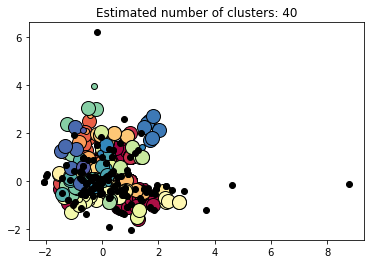

In [222]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = scaled_AGES_data_imp_nomissing_tr[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = scaled_AGES_data_imp_nomissing_tr[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### Create final datasets - PCA
- Create imputed data for PCA
- Run PCA for each cluster (if vars don't fall into any clusters keep it as is)
- Keep the 1st PC for each cluster

In [91]:
X_imp = scaled_AGES_data_imp_nomissing.drop(["TOTAL_BRAIN", "TBV_ICV", "TBV_4thQ"], axis=1)
print(X_imp.shape)
X_imp.head()

(3116, 746)


,AGE,WEIGHT,HEIGHT,ANPMMAC,BMI,HRES50,FFM,FAT,FATPERCENT,HEALSTAT,CIMTMEAN,CIMTMAX,STIFFNESS,CIMTLUMEN,DC_KPA,DC_KPA2,ECGBM100,ECGBM101,ECGBM102,ECGBM111,ECGBM112,ECGBM113,ECGBM114,ECGBM115,ECGBM116,ECGBM117,ECGBM121,ECGBM122,ECGBM123,ECGBM124,ECGBM125,ECGBM126,ECGBM127,ECGBM128,ECGBM131,ECGBM132,ECGBM133,ECGBM134,ECGBM135,ECGBM136,ECGBM210,ECGBM220,ECGBM230,ECGBM240,ECGBM250,ECGBM310,ECGBM320,ECGBM330,ECGBM340,ECGBM411,ECGBM412,ECGBM420,ECGBM430,ECGBM440,ECGBM510,ECGBM520,ECGBM530,ECGBM540,ECGBM610,ECGBM621,ECGBM622,ECGBM623,ECGBM630,ECGBM641,ECGBM642,ECGBM650,ECGBM660,ECGBM680,ECGBM711,ECGBM712,ECGBM721,ECGBM722,ECGBM730,ECGBM740,ECGBM750,ECGBM760,ECGBM770,ECGBM780,ECGBM811,ECGBM812,ECGBM813,ECGBM814,ECGBM815,ECGBM821,ECGBM822,ECGBM823,ECGBM824,ECGBM831,ECGBM832,ECGBM833,ECGBM834,ECGBM841,ECGBM842,ECGBM851,ECGBM852,ECGBM861,ECGBM862,ECGBM863,ECGBM864,ECGBM870,ECGBM880,ECGBM890,ECGBM910,ECGBM920,ECGBM930,ECGBM941,ECGBM942,ECGBM950,ECGBM981,ECGBM982,MI_ECG,TINN,L500,L1000,L2000,L3000,L4000,L6000,L8000,LC1000,R500,R1000,R2000,R3000,R4000,R6000,R8000,RC1000,LMFHL25_B,HFHL25_B,INTERHL25_B,LMFHL25_W,HFHL25_W,INTERHL25_W,LMFHL40_B,HFHL40_B,INTERHL40_B,LMFHL40_W,HFHL40_W,INTERHL40_W,WHO_M1,WHO_M2,WHO_M3,WHO_M4,WHO_M5,WHO_M6,WHO_SUM,METSYN_WHO,METSYN,M1,M2,M3,M4,M5,TOTMETSYN,MICROBLD,FRONTAL,PARIETAL,OCCIPITAL,TEMPORAL,FRONTALR,PARIETALR,OCCIPITALR,TEMPORALR,FRONTALL,PARIETALL,OCCIPITALL,TEMPORALL,WMLLOAD,WMLLOADR,WMLLOADL,SCHELTENS,ACHTEN1,ACHTEN2,ACHTEN3,ACHTEN5,ACHTEN6,ACHTEN7,SCHELTEN2,ACHTEN4,ACHTEN8,ACHTEN9,CONFN,CONFNF,CONFNP,CONFNB,TOTVL,FRONTALVL,PARIETALVL,OCCIPITALVL,TEMPORALVL,PVSCORE,PVSCOREF,PVSCOREP,PVSCOREB,PVSCORER,PVSCOREL,SUBCORTYN,VRSYN,VRS2YN,SCVRSYN,INFARCTYN,INFCORTYN,INFCERYN,BIG_MICROBLD,MBLPLC_1,MBLPLC_2,MBLPLC_3,MBLPLC_5,DGB_TSPN,DGB_PROB,DGF_TSPN,DGF_PROB,DSS_TCM,DSS_TC,DSS_TW,DSS_PCC,DSS_PROB,MM_SCORE,ME_PROB,ST1_TIMS,ST1_NUMC,ST1_TOTC,ST1_TOTE,ST1_TFSC,STP_PROB,ST2_TIMS,ST2_NUMC,ST2_TOTC,ST2_TOTE,ST2_TFSC,ST3_TIMS,ST3_NUMC,ST3_TOTC,ST3_TOTE,ST3_TFSC,FC_TOTC,FC_TOTE,FC_TOTSK,FC_PROB,CVL1TOTC,CVL2TOTC,CVL3TOTC,CVL4TOTC,CVLLTOTC,CVLRTOTC,CVL14TOT,CVL14LOT,CVLTPROB,CVLLPROB,MSWMMELA,MSWMSBET,MSWMSBE4,MSWMSBE6,MSWMSBE8,MSWMSWET,MSWMSWE4,MSWMSWE6,MSWMSWE8,MSWMSDET,MSWMSDE4,MSWMSDE6,MSWMSDE8,MSWMSSTR,MSWMSTOT2,MSW2PRO1,MSW2PRO2,ZCVLT,ZCVLTD,ZDSST,ZFCOMP,ZDIGB,ZDIGF,ZMMSE,ZCANTAB,ZSTROOP1,ZSTROOP2,ZSTROOP3,MEMORY,WORKING,SPEED,MEMORY2,SPEED2,WORKING2,COMPMEM,COMPWORK,COMPSPEED,GDS_ANS,GDS_SCORE,GDSI_SCORE,CORNCAL1,CORNCAL2,ARCHCAL1,ARCHCAL2,DAORCAL1,DAORCAL2,ALLCAL1,ALLCAL2,CT01ACV1,CT01ACM1,CT01ACD1,CT01ACV2,CT01ACM2,CT01ACD2,AVGVERTCOMP,VBCSAL1,VBCSAL2,AVGVERTSZ,DCIV3,DCIV4,DEBMD2,DTBMD2,DIBMD2,DIBMD3,DTBMD3,APDXAL1L2,LATDXAL1L2,DCOBMD,MCBMD,TRABECULARCALCIUM,CORTICALCALCIUM,TOTALCALCIUM,CT02NIBD,CT02NIVL,CT02NTBD,CT02NCBD,CT02NCVL,CT02TIBD,CT02TIVL,CT02TTBD,CT02TCBD,CT02FIBD,CT02FIVL,CT02FTBD,CT02FTBC,CT02FTVL,CT02FCBD,CT02FCBC,CT02FCVL,CT02MNCS,CT02MXCS,CT02AXIS,CT02NBMD,CT02TOBD,NMODULUS,NSTIFF,MEDULLARYVOL,ESTNECKCOMPSTR,AVGTHIM,AVGTHMUS,AVGTHSQ,MAFA,CT30LTOTAL,CT30LTOTALFAT,CT30LTOTALLEAN,CT30LSUBFAT,CT30LFASQFAT,CT30LTOTALMUSCLETOT,CT30LTOTALMUSCLEFAT,CT30LTOTALMUSCLELEAN,CT30RTOTAL,CT30RTOTALFAT,CT30RTOTALLEAN,CT30RSUBFAT,CT30RFASQFAT,CT30RTOTALMUSCLETOT,CT30RTOTALMUSCLEFAT,CT30RTOTALMUSCLELEAN,CT30LTOTALSHAFT,CT30LSHAFTCORT,CT30LSHAFTMED,CT31CIRC,CT31SAGDIAM,CT31TOTBODYAREA,CT31TOTBODYFATAREA,CT31TOTBODYLEANAREA,CT31VFFATAREA,CT31SQFATAREA,PIXIBMD,TUGOSEC1,TUGOSEC2,WALKSEC1,WALKNUM1,WALKSEC2,WALKNUM2,WALKSEC3,WALKNUM3,WALKSEC4,WALKNUM4,STEPS_NORMAL,STEPS_FAST,TIME_NORMAL,TIME_FAST,ISOMMASTLEG,ISOMACTRLEG,LEGSTRNM,LWRLEGLTH,ISOMMASTHAND,ISOMACTRHAND,S_CHOL,S_HDLC2,S_LDL,S_TG,S_GLU,S_HBA1C,S_HBA1,S_CRP_S,S_INSULIN,HTNMED,DRESS,BATHE,TRANSFER,EAT,WALK,ADL,HEALHTN1,HEALHTN2,HEALHTN3,HEALHTN4,HEALH401,HEALH402,HEALH403,HEALH404,DIS,DMS,EMA,INSOMNIA,COUNTMIGR,BETTEREYE,QUE2ALEV,PASSDSST,PASSMMSE,PASSCOG1,PASSDSST_S,PASSMMSE_S,PASSCOG1_S,DSS_CUTOFF,MM_CUTOFF,RLSQ1,RLSQ2,S_AL_KR,S_BA_N,S_BA_PCT,S_CRE_S,s_stand

In [412]:
def PCA_Cluster(X_data, cluster_data, n_component = 1):
    appended_data = []
    # Importing PCA
    from sklearn import decomposition
    pca = decomposition.PCA(n_components = n_component)

    # Looping over each cluster
    for cluster in np.unique(cluster_data.index):
        if cluster >= 0 :
            cluster_var_list = cluster_data[cluster_data.index == cluster].values.tolist()
            # fit_transform
            PC_data = pca.fit_transform(X_data[cluster_var_list])        
            appended_data.append(pd.DataFrame(PC_data).rename(columns={0:f"""PC1_cluster_{cluster}"""}))
            
        elif cluster == -1:
            cluster_var_list = cluster_data[cluster_data.index == cluster].values.tolist()
            appended_data.append(X_data[cluster_var_list].reset_index(drop=True))

    new_df = pd.concat(appended_data, axis=1)
    return new_df

In [413]:
cluster_PCA_data = PCA_Cluster(X_data = X_imp,
            cluster_data = cluster_label)

In [414]:
cluster_PCA_data.head(15)

,AGE,S_GLU,S_TG,S_HDLC2,ISOMACTRHAND,ISOMMASTHAND,LWRLEGLTH,TOTMETSYN,MICROBLD,LEGSTRNM,ISOMACTRLEG,ISOMMASTLEG,PIXIBMD,CT31TOTBODYLEANAREA,CT30LSHAFTMED,ACHTEN1,MAFA,CT02NCBD,CT02NTBD,SCHELTEN2,CT01ACD2,CT01ACM2,CT01ACV2,CT01ACD1,CT01ACM1,CT01ACV1,S_HBA1C,CORNCAL2,WHO_SUM,S_CRP_S,S_U_RBK,S_U_NIT,S_U_HBK,CVL14LOT,S_U_E,S_RDW,S_PDW,R8000,S_NE_PCT,S_NE_N,S_MPV,S_MO_PCT,S_MO_N,S_MCHC,S_LY_PCT,S_LY_N,S_CRE_U,S_BA_PCT,S_BA_N,MM_CUTOFF,DSS_CUTOFF,QUE2ALEV,COUNTMIGR,ADL,S_INSULIN,S_HBA1,CORNCAL1,GDSI_SCORE,GDS_SCORE,MSWMSWE6,ST1_TIMS,ST1_NUMC,ST1_TOTC,ST1_TOTE,ST1_TFSC,STP_PROB,ST2_TIMS,ST2_NUMC,ST2_TOTC,ST2_TOTE,ST2_TFSC,ST3_TIMS,ST3_NUMC,ST3_TOTC,ST3_TOTE,ST3_TFSC,MSWMSWE4,FC_TOTE,FC_TOTSK,MSWMSBE4,CVL1TOTC,MSWMMELA,CVLLPROB,CVLTPROB,MM_SCORE,MSWMSDE4,DSS_PCC,DSS_TW,OCCIPITALVL,TEMPORALVL,GDS_ANS,PVSCOREF,WORKING2,PVSCOREB,WORKING,ZSTROOP3,ZSTROOP2,ZSTROOP1,ZMMSE,ZDIGF,S_U_PH,ZDIGB,MSW2PRO1,BIG_MICROBLD,MBLPLC_1,MBLPLC_2,MBLPLC_3,MBLPLC_5,DGB_TSPN,DGB_PROB,DGF_TSPN,DGF_PROB,MSWMSSTR,MSWMSDE6,MSW2PRO2,S_UA,S_U_GLUK,GLU,ECGBM131,ECGBM132,ECGBM133,ECGBM134,ECGBM135,ECGBM136,ECGBM210,ECGBM220,ECGBM230,ECGBM240,p_YEAR,ECGBM310,CHEW_YEARS,CH_YEAR,ECGBM330,ECGBM411,ECGBM412,ECGBM420,ECGBM430,ECGBM440,ECGBM510,ECGBM520,ECGBM530,CHEWAYEAR,ECGBM610,ECGBM621,CIGARAYEAR,dmmedinsulincount,CIGAR_YEARS,ECGBM127,ECGBM126,ECGBM125,EDUCATION_2.0,alcoholgweek_mid,alcoholgweek,QUE2AMAQ,HRES50,QUE2AMAO,QUE2ALHM,QUE2ALHO,HEALSTAT,swimtime_Sh,swimtime_wh,physactivpres,CIMTLUMEN,DC_KPA,DC_KPA2,ECGBM100,NMPAN,ECGBM102,ECGBM111,ECGBM112,ECGBM113,ECGBM114,ECGBM115,ECGBM116,ECGBM117,ECGBM121,ECGBM122,ECGBM123,ECGBM124,ECGBM630,S_WBC,ECGBM641,ECGBM650,ECGBM831,ECGBM832,ECGBM833,ECGBM834,ECGBM841,U_GLUK,ECGBM851,MCHC,LY_pct,NE_pct,MO_pct,BA_pct,ECGBM870,U_pH,ECGBM880,ECGBM910,ECGBM920,ECGBM930,ECGBM941,ECGBM942,ECGBM950,ECGBM981,ECGBM982,WBC,HDLC2,UA,TG,INSULIN,ECGBM890,CRE_U,EY11SLCY,EY11SLAX,plaq_n,plaq_max,ECGBM711,leisure_soc2,ECGBM721,ECGBM722,nmed,ECGBM730,ECGBM740,CVLRTOTC,EY11SRCY,ECGBM760,EY11SRAX,ECGBM770,ECGBM813,leisure_soc,ECGBM812,ECGBM750,ECGBM811,PC1_cluster_0,PC1_cluster_1,PC1_cluster_2,PC1_cluster_3,PC1_cluster_4,PC1_cluster_5,PC1_cluster_6,PC1_cluster_7,PC1_cluster_8,PC1_cluster_9,PC1_cluster_10,PC1_cluster_11,PC1_cluster_12,PC1_cluster_13,PC1_cluster_14,PC1_cluster_15,PC1_cluster_16,PC1_cluster_17,PC1_cluster_18,PC1_cluster_19,PC1_cluster_20,PC1_cluster_21,PC1_cluster_22,PC1_cluster_23,PC1_cluster_24,PC1_cluster_25,PC1_cluster_26,PC1_cluster_27,PC1_cluster_28,PC1_cluster_29,PC1_cluster_30,PC1_cluster_31,PC1_cluster_32,PC1_cluster_33,PC1_cluster_34,PC1_cluster_35,PC1_cluster_36,PC1_cluster_37,PC1_cluster_38,PC1_cluster_39
0,-0.343155,0.133590,-0.057232,0.241278,1.175738,0.719704,0.259484,-0.050960,-0.178688,1.389267,-0.506702,1.547633,-0.754557,1.476436,1.958686,0.436074,0.896828,-0.644466,-1.431274,-0.314321,0.608077,0.762806,0.886106,1.743517,0.791190,0.544159,-0.302276,-0.085950,-0.313669,-0.517411,-0.139945,-0.462459,-0.348184,-1.996865,0.522863,-0.044917,0.545274,-1.404450,-2.055270,-1.295559,0.791388,0.920043,-0.190365,0.194865,1.915885,0.316776,0.798429,2.265570,2.499797,1.284665,1.031142,0.292528,-0.474218,0.0,-0.078158,-0.552978,-0.083308,-0.610191,-0.611239,0.153191,-0.733924,0.017917,0.339325,-0.356953,-0.342093,0.0,-1.226025,0.028651,-0.095653,0.106343,0.400590,-0.671972,0.081922,0.794744,-0.797198,-0.989016,-0.333322,4.606243,8.756480,0.656391,1.387432,-0.654762,0.0,0.0,0.402009,-0.244075,-0.731567,1.498266,-0.034189,-0.245127,0.241621,-0.438122,0.291862,0.192404,0.293413,-0.671972,-1.226025,-0.733924,0.402009,0.701672,0.877671,0.165430,0.0,-0.305365,-0.133867,-0.065312,-0.112744,-0.177250,0.165430,0.0,0.701672,0.0,0.655267,0.050262,0.0,0.367759,-0.101788,0.133590,-0.057096,-0.118291,-0.172459,-0.098597,-0.025343,-0.114035,-0.244671,-0.017917,-0.025343,-0.017917,2.926841,-0.161284,-0.084352,-0.125144,-0.062177,-0.033874,-0.087802,-0.155974,-0.160485,-0.08287,-0.056741,-0.234314,-0.288990,-0.113289,-0.017917,-0.017917,0.667279,-0.

In [416]:
Y_TBV_ICV_imp = scaled_AGES_data_imp_nomissing['TBV_ICV'].reset_index(drop=True)
print(Y_TBV_ICV_imp.shape)
Y_TBV_ICV_imp.head()

(3116,)


0    0.743577
1    0.801323
2    0.726184
3    0.748768
4    0.740467
Name: TBV_ICV, dtype: float64

In [417]:
Y_TBV_4thQ_imp = scaled_AGES_data_imp_nomissing['TBV_4thQ'].reset_index(drop=True)
print(Y_TBV_4thQ_imp.shape)
Y_TBV_4thQ_imp.head()

(3116,)


0    1
1    0
2    0
3    0
4    1
Name: TBV_4thQ, dtype: int64

### Ensemble methods: boosting - Gradient Boosting

Sequential improvement of models by training on their errors

![](https://littleml.files.wordpress.com/2017/03/boosted-trees-process.png?w=992)

See also: http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html

In [418]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.model_selection import cross_val_score, KFold   #Additional scklearn functions
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn import linear_model, decomposition
import sklearn.metrics
from sklearn.pipeline import Pipeline

In [419]:
def modelfit(alg, dtrain, predictors, outcome, performCV=True, printFeatureImportance=True, cv_folds = 5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], outcome)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], outcome, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(outcome.values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(outcome, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        %matplotlib inline
        fig=plt.figure(figsize=(5, 30))
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.sort_values(ascending=False).nlargest(50).plot(kind='barh', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8976
AUC Score (Train): 0.951664
CV Score : Mean - 0.8155612 | Std - 0.01759072 | Min - 0.7845263 | Max - 0.8444027


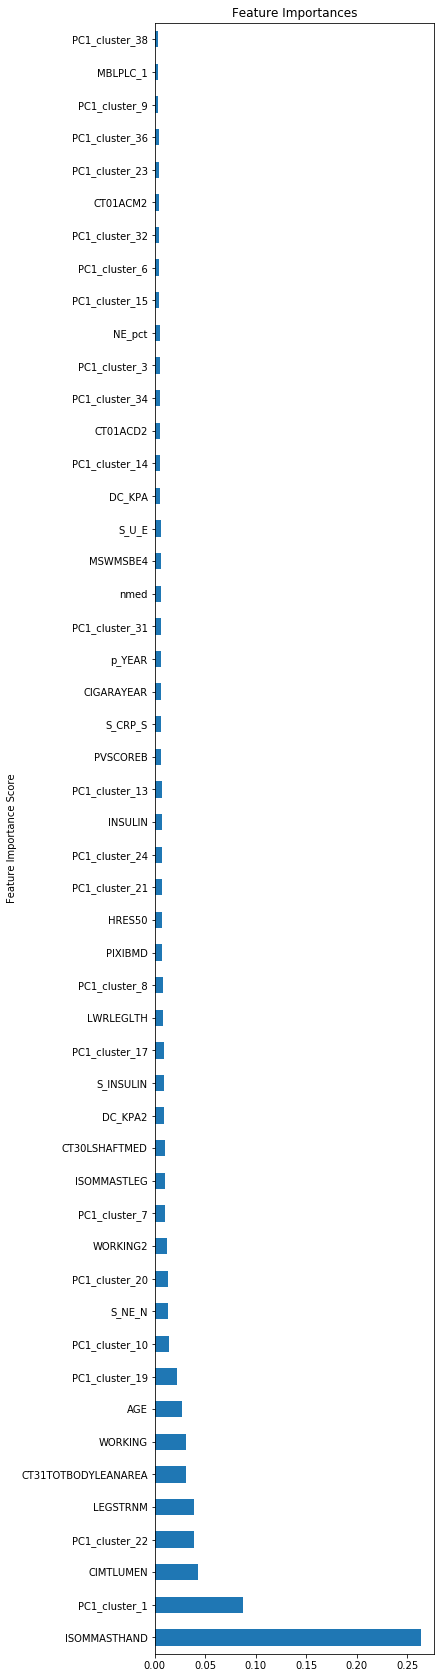

In [421]:
kf = KFold(n_splits=10, shuffle=True, random_state=99)
#Choose all predictors except target
predictors = [x for x in cluster_PCA_data.columns]
gbm0 = GradientBoostingClassifier(random_state=99)
modelfit(gbm0, cluster_PCA_data, predictors, Y_TBV_4thQ_imp, cv_folds=kf)

In [422]:
gbm0

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=99, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [37]:
gbm = GradientBoostingClassifier(random_state=99)

In [38]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': range(10, 100, 10),
    'gbm__learning_rate': [0.1, 0.01, 0.05, 0.001],
    # Number of trees in random forest
    "gbm__n_estimators": range(100, 501, 50),
    # Number of features to consider at every split
    'gbm__max_features': ['auto', 'sqrt'],
    # Maximum number of levels in tree
    'gbm__max_depth':range(5, 56,10),
    # Minimum number of samples required to split a node
    'gbm__min_samples_split':range(100, 501, 200),
    # Minimum number of samples required at each leaf node
    "gbm__min_samples_leaf": [30, 50]
}

kf = KFold(n_splits=10, shuffle=True, random_state=99)

gsearch2 = GridSearchCV( pipe, param_grid = param_grid, scoring='roc_auc', n_jobs= -1, cv= kf)
gsearch2.fit(X_imp, Y_TBV_4thQ_imp)

print("\nModel Report")
print("Best parameter (CV score=%0.3f):" % gsearch2.best_score_)

print(gsearch2.best_params_)
print('# components:', gsearch2.best_estimator_.named_steps['pca'].n_components)
print('GBM:', gsearch2.best_estimator_.named_steps['gbm'])

print("\nModel Estimator")
print(gsearch2)


Model Report
Best parameter (CV score=0.826):
{'gbm__learning_rate': 0.05, 'gbm__max_depth': 5, 'gbm__max_features': 'auto', 'gbm__min_samples_leaf': 50, 'gbm__min_samples_split': 500, 'gbm__n_estimators': 100, 'pca__n_components': 90}
# components: 90
GBM: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=5,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=500,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=99, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Model Estimator
GridSearchCV(cv=KFold(n

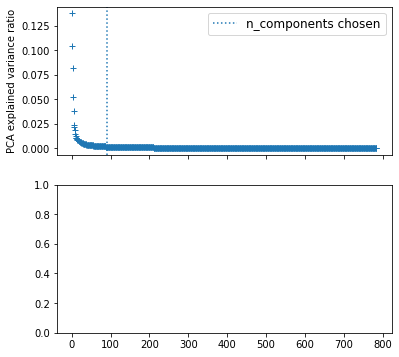

In [39]:
# Plot the PCA spectrum
pca.fit(X_imp)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(gsearch2.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

In [40]:
best_model = gsearch2.best_estimator_
#feat_importances = pd.Series(best_model.feature_importances_, index=X.columns)
#feat_importances.nlargest(200)

## Save the best model

In [4]:
from sklearn.externals import joblib
joblib.dump(best_model, 'PCA_GBM_TBV_4thQ_imp_model.gz')

['PCA_GBM_TBV_4thQ_imp_model.gz']

In [3]:
from sklearn.externals import joblib

best_model = joblib.load('PCA_GBM_TBV_4thQ_imp_model.pkl')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-pa

In [5]:
print(best_model)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=90,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('gbm',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.05, loss='deviance',
                                            max_depth=5, max_features='auto',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=50,
                                            min_samples_split=500,
                                            min_weight_fraction_leaf=0.0,
                                           